Esse é um clássico problema de Regressão de uma série temporal.  
Os dados estão dispostos em uma linha do tempo, alguns cuidados devem ser tomados ao manipular e criar modelos para
esses tipos de problemas.  
Vamos juntos tentar criar um modelo para prever o volume de Chuva!

# Importando Bibliotecas

In [425]:
import optuna
import shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

from scipy import special
from scipy import stats

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost as xgb

## Classes para o projeto

Esse problema possui sérios problemas relacionados a desbalanceamento de dados, Essa função tem como objetivo melhorar a distribuição dos dados target para melhorar o desempenho do modelo preditivo.

In [426]:
class Transformer():
    '''
    Essa classe pode ser usada para aplicar transformações e transformações inversas à variável target.
    Transformações suportadas:
        -> square root
        -> log
        -> box cox
    '''
    def __init__(self):
        self._lambda = 0 # init lambda -> required for box cox inverse transformation

    def calculate_lambda(self, data):
        pt = PowerTransformer(method='yeo-johnson')
        data = pd.DataFrame({'x':data})
        pt.fit(data)
        self._lambda = pt.lambdas_[0]
    
    def apply_transformation(self, data_in, transform_key = "no_transformation"):
        '''
        Esta função aplica a transformação de acordo com a chave_transformadora à entrada fornecida.
        
        Args:
            data_in (np.array): Input data para transformar
            transform_key (string): Chave de qual transformação aplicar (pode ser: square_root, log, boxcox, no_transformation)
        
        Returns: 
            data_transformed (np.array): Os dados transformados
        '''
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = np.sqrt(data_in)
        elif transform_key == "log":
            data_transformed = np.log(data_in)
        elif transform_key == "boxcox":
            self.calculate_lambda(data_in)
            data_transformed = special.boxcox1p(data_in, self._lambda)
        else:
            raise ValueError(f"{transform_key} é uma opcão inválida!")
        
        return data_transformed
    
    def apply_inverse_transformation(self, data_in, transform_key = "no_transformation"):
        '''
        Esta função aplica a transformação inversa de acordo com a chave_transformadora  fornecida.
        
        Args:
            data_in (np.array): Input data para transformar
            transform_key (string): Chave de qual transformação aplicar (pode ser: square_root, log, boxcox, no_transformation)
        
        Returns: 
            data_transformed (np.array): Os dados transformados
        '''
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = data_in**2
        elif transform_key == "log":
            data_transformed = np.exp(data_in)
        elif transform_key == "boxcox":
            data_transformed = special.inv_boxcox1p(data_in, self._lambda)
        else:
            raise ValueError(f"{transform_key} é uma opcão inválida!")
        
        return data_transformed

## Olhando para os Dados

In [427]:
estacao_df = pd.read_csv("Data/Estacao_Convencional.csv")
sensor_df = pd.read_csv("Data/Sensor_FieldPRO.csv")

In [428]:
sensor_df.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
0,2020-09-30T23:00:00Z,38.0,31.366,9412,0,45123,30
1,2020-10-01T00:00:00Z,NaN,NaN,9412,0,45025,31
2,2020-10-01T01:00:00Z,39.0,31.366,9419,0,44923,31
3,2020-10-01T02:00:00Z,39.0,31.322,9419,0,44825,31
4,2020-10-01T03:00:00Z,38.0,31.240,9416,0,44728,31


Existem poucos dados nulos na base de dados do sensor, vamos ver uma forma de preencher esses valores.

In [429]:
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datetime – utc       1711 non-null   object 
 1   air_humidity_100     1705 non-null   float64
 2   air_temperature_100  1705 non-null   float64
 3   atm_pressure_main    1711 non-null   int64  
 4   num_of_resets        1711 non-null   int64  
 5   piezo_charge         1711 non-null   int64  
 6   piezo_temperature    1711 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 93.7+ KB


In [430]:
sensor_df.describe()

,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature
count,1705.000000,1705.000000,1711.000000,1711.000000,1711.000000,1711.000000
mean,60.238710,24.660940,9432.838106,1.646406,42462.030392,24.910579
std,22.100228,6.174219,26.378333,1.090382,13038.238287,8.374122
min,13.000000,12.360000,9350.000000,0.000000,16950.000000,11.000000
25%,41.000000,19.900000,9416.000000,1.000000,32020.000000,18.000000
50%,61.000000,23.020000,9433.000000,2.000000,41765.000000,22.000000
75%,80.000000,29.400000,9450.000000,3.000000,53769.000000,32.000000
max,99.000000,42.664000,9507.000000,3.000000,65533.000000,47.000000


## Feature Engineering

Vamos transformar a coluna de data para o formato datetime e então vamos criar novas colunas que podem fazer sentido para o nosso modelo!  
As colunas são:  
<b> Year </b>  
<b> Month </b>  
<b> Day </b>  
<b> Hour </b>  
<b> Day of year </b>  

In [431]:
sensor_df["Datetime – utc"] = pd.to_datetime(sensor_df["Datetime – utc"].str.replace("Z", ""), format='ISO8601')

In [432]:
sensor_df["Year"] = sensor_df["Datetime – utc"].dt.year
sensor_df["Month"] = sensor_df["Datetime – utc"].dt.month
sensor_df["Day"] = sensor_df["Datetime – utc"].dt.day
sensor_df["Hour"] = sensor_df["Datetime – utc"].dt.hour
sensor_df["Day of year"] = sensor_df["Datetime – utc"].dt.dayofyear

In [433]:
sensor_df.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,Year,Month,Day,Hour,Day of year
0,2020-09-30 23:00:00,38.0,31.366,9412,0,45123,30,2020,9,30,23,274
1,2020-10-01 00:00:00,NaN,NaN,9412,0,45025,31,2020,10,1,0,275
2,2020-10-01 01:00:00,39.0,31.366,9419,0,44923,31,2020,10,1,1,275
3,2020-10-01 02:00:00,39.0,31.322,9419,0,44825,31,2020,10,1,2,275
4,2020-10-01 03:00:00,38.0,31.240,9416,0,44728,31,2020,10,1,3,275


É muito comum quando temos valores nulos, ou descartamos essas linhas ou então usamos o valor da média, moda ou mediana.  
Quando é um problema de Série temporal também podemos usar essas técnicas, porém devemos ficar atentos pois caso exista uma sasonalidade nos dados
usar a média de todos os dados não é a melhor opção.  
Para esse tipo de caso, o mais ideal é agrupar os dados em uma determinada frequencia e então usar a média dessa frequencia para preencher os valores
nulos referente a cada época.  
Faremos isso a seguir!

In [434]:
grouped_sensor = sensor_df.groupby(pd.Grouper(key="Datetime – utc", freq="D")).mean().reset_index()
grouped_sensor["Year"] = grouped_sensor["Datetime – utc"].dt.year
grouped_sensor["Month"] = grouped_sensor["Datetime – utc"].dt.month
grouped_sensor["Day"] = grouped_sensor["Datetime – utc"].dt.day
grouped_sensor["hour"] = grouped_sensor["Datetime – utc"].dt.hour

In [435]:
grouped_sensor.head()

,Datetime – utc,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,Year,Month,Day,Hour,Day of year,hour
0,2020-09-30,38.000000,31.366000,9412.000000,0.0,45123.000000,30.000000,2020,9,30,23.000000,274.0,0
1,2020-10-01,37.058824,31.846588,9418.954545,0.0,43633.954545,31.454545,2020,10,1,11.318182,275.0,0
2,2020-10-02,38.190476,31.143905,9402.272727,0.0,40589.454545,30.409091,2020,10,2,11.863636,276.0,0
3,2020-10-03,38.625000,30.711167,9413.791667,0.0,38219.458333,30.416667,2020,10,3,11.500000,277.0,0
4,2020-10-04,55.791667,26.250917,9438.791667,0.0,35915.333333,27.166667,2020,10,4,11.500000,278.0,0


In [436]:
sensor_df = (sensor_df.
             set_index(["Year", "Month", "Day"]).
             combine_first(grouped_sensor.set_index(["Year", "Month", "Day"])).
             reset_index()[sensor_df.columns])
sensor_df.rename(columns={"Datetime – utc": "Datetime"}, inplace=True)

In [437]:
sensor_df.head()

,Datetime,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,Year,Month,Day,Hour,Day of year
0,2020-09-30 23:00:00,38.000000,31.366000,9412.0,0.0,45123.0,30.0,2020,9,30,23.0,274.0
1,2020-10-01 00:00:00,37.058824,31.846588,9412.0,0.0,45025.0,31.0,2020,10,1,0.0,275.0
2,2020-10-01 01:00:00,39.000000,31.366000,9419.0,0.0,44923.0,31.0,2020,10,1,1.0,275.0
3,2020-10-01 02:00:00,39.000000,31.322000,9419.0,0.0,44825.0,31.0,2020,10,1,2.0,275.0
4,2020-10-01 03:00:00,38.000000,31.240000,9416.0,0.0,44728.0,31.0,2020,10,1,3.0,275.0


In [438]:
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             1711 non-null   datetime64[ns]
 1   air_humidity_100     1711 non-null   float64       
 2   air_temperature_100  1711 non-null   float64       
 3   atm_pressure_main    1711 non-null   float64       
 4   num_of_resets        1711 non-null   float64       
 5   piezo_charge         1711 non-null   float64       
 6   piezo_temperature    1711 non-null   float64       
 7   Year                 1711 non-null   int32         
 8   Month                1711 non-null   int32         
 9   Day                  1711 non-null   int32         
 10  Hour                 1711 non-null   float64       
 11  Day of year          1711 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int32(3)
memory usage: 140.5 KB


Feito isso é olhar de olhar para os dados de chuva da estação. Os dados parecem okay, não existem valores nulos.  
Porém os dados de sensores cobrem uma faixa de tempo maior do que os dados da estação, quando fizermos o merge dos dois dados 
iremos diminuir a quantidade de dados que serão usados no modelo!

In [439]:
estacao_df.head()

,data,Hora (Brasília),chuva
0,2020-09-01,00:00:00,0.0
1,2020-09-01,01:00:00,0.0
2,2020-09-01,02:00:00,0.0
3,2020-09-01,03:00:00,0.0
4,2020-09-01,04:00:00,0.0


In [440]:
estacao_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   data             2256 non-null   object 
 1   Hora (Brasília)  2256 non-null   object 
 2   chuva            2256 non-null   float64
dtypes: float64(1), object(2)
memory usage: 53.0+ KB


In [441]:
estacao_df["Datetime"] = pd.to_datetime(estacao_df["data"] + "T" + estacao_df["Hora (Brasília)"])

In [442]:
estacao_df.head()

,data,Hora (Brasília),chuva,Datetime
0,2020-09-01,00:00:00,0.0,2020-09-01 00:00:00
1,2020-09-01,01:00:00,0.0,2020-09-01 01:00:00
2,2020-09-01,02:00:00,0.0,2020-09-01 02:00:00
3,2020-09-01,03:00:00,0.0,2020-09-01 03:00:00
4,2020-09-01,04:00:00,0.0,2020-09-01 04:00:00


In [443]:
sensor_merged = sensor_df.merge(estacao_df[["Datetime", "chuva"]], on="Datetime", how="left")
sensor_merged.head()

,Datetime,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,Year,Month,Day,Hour,Day of year,chuva
0,2020-09-30 23:00:00,38.000000,31.366000,9412.0,0.0,45123.0,30.0,2020,9,30,23.0,274.0,0.0
1,2020-10-01 00:00:00,37.058824,31.846588,9412.0,0.0,45025.0,31.0,2020,10,1,0.0,275.0,0.0
2,2020-10-01 01:00:00,39.000000,31.366000,9419.0,0.0,44923.0,31.0,2020,10,1,1.0,275.0,0.0
3,2020-10-01 02:00:00,39.000000,31.322000,9419.0,0.0,44825.0,31.0,2020,10,1,2.0,275.0,0.0
4,2020-10-01 03:00:00,38.000000,31.240000,9416.0,0.0,44728.0,31.0,2020,10,1,3.0,275.0,0.0


Vamos fazer o merge das duas coleções de dados e definir uma ordem das colunas, apenas para melhorar a visualização.

In [444]:
ordem_colunas = ['Datetime', 'Year', 'Month', 'Day', 'Hour', 'Day of year', 'air_humidity_100', 'air_temperature_100',
'atm_pressure_main', 'num_of_resets', 'piezo_charge', 'piezo_temperature','chuva']
sensor_merged = sensor_merged[ordem_colunas]

In [445]:
sensor_merged.head()

,Datetime,Year,Month,Day,Hour,Day of year,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
0,2020-09-30 23:00:00,2020,9,30,23.0,274.0,38.000000,31.366000,9412.0,0.0,45123.0,30.0,0.0
1,2020-10-01 00:00:00,2020,10,1,0.0,275.0,37.058824,31.846588,9412.0,0.0,45025.0,31.0,0.0
2,2020-10-01 01:00:00,2020,10,1,1.0,275.0,39.000000,31.366000,9419.0,0.0,44923.0,31.0,0.0
3,2020-10-01 02:00:00,2020,10,1,2.0,275.0,39.000000,31.322000,9419.0,0.0,44825.0,31.0,0.0
4,2020-10-01 03:00:00,2020,10,1,3.0,275.0,38.000000,31.240000,9416.0,0.0,44728.0,31.0,0.0


In [446]:
sensor_merged.dropna(inplace=True)
sensor_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1528 entries, 0 to 1528
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             1528 non-null   datetime64[ns]
 1   Year                 1528 non-null   int32         
 2   Month                1528 non-null   int32         
 3   Day                  1528 non-null   int32         
 4   Hour                 1528 non-null   float64       
 5   Day of year          1528 non-null   float64       
 6   air_humidity_100     1528 non-null   float64       
 7   air_temperature_100  1528 non-null   float64       
 8   atm_pressure_main    1528 non-null   float64       
 9   num_of_resets        1528 non-null   float64       
 10  piezo_charge         1528 non-null   float64       
 11  piezo_temperature    1528 non-null   float64       
 12  chuva                1528 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int3

In [447]:
sensor_merged

,Datetime,Year,Month,Day,Hour,Day of year,air_humidity_100,air_temperature_100,atm_pressure_main,num_of_resets,piezo_charge,piezo_temperature,chuva
0,2020-09-30 23:00:00,2020,9,30,23.0,274.0,38.000000,31.366000,9412.0,0.0,45123.0,30.0,0.0
1,2020-10-01 00:00:00,2020,10,1,0.0,275.0,37.058824,31.846588,9412.0,0.0,45025.0,31.0,0.0
2,2020-10-01 01:00:00,2020,10,1,1.0,275.0,39.000000,31.366000,9419.0,0.0,44923.0,31.0,0.0
3,2020-10-01 02:00:00,2020,10,1,2.0,275.0,39.000000,31.322000,9419.0,0.0,44825.0,31.0,0.0
4,2020-10-01 03:00:00,2020,10,1,3.0,275.0,38.000000,31.240000,9416.0,0.0,44728.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,2020-12-03 19:00:00,2020,12,3,19.0,338.0,86.000000,20.880000,9412.0,3.0,35217.0,20.0,0.0
1525,2020-12-03 20:00:00,2020,12,3,20.0,338.0,90.000000,20.980000,9409.0,3.0,35132.0,19.0,0.0
1526,2020-12-03 21:00:00,2020,12,3,21.0,338.0,93.000000,20.620000,9408.0,3.0,35068.0,20.0,0.0
1527,2020-12-03 22:00:00,2020,12,3,22.0,338.0,94.000000,20.080000,9406.0,3.0,35007.0,19.0,0.0


## Explorando os Dados

Vamos dar uma olhada para a correlação das features, pra gente ter certeza que não existe nenhuma feature que sozinha tenha muita correlação com a variável target do nosso modelo.

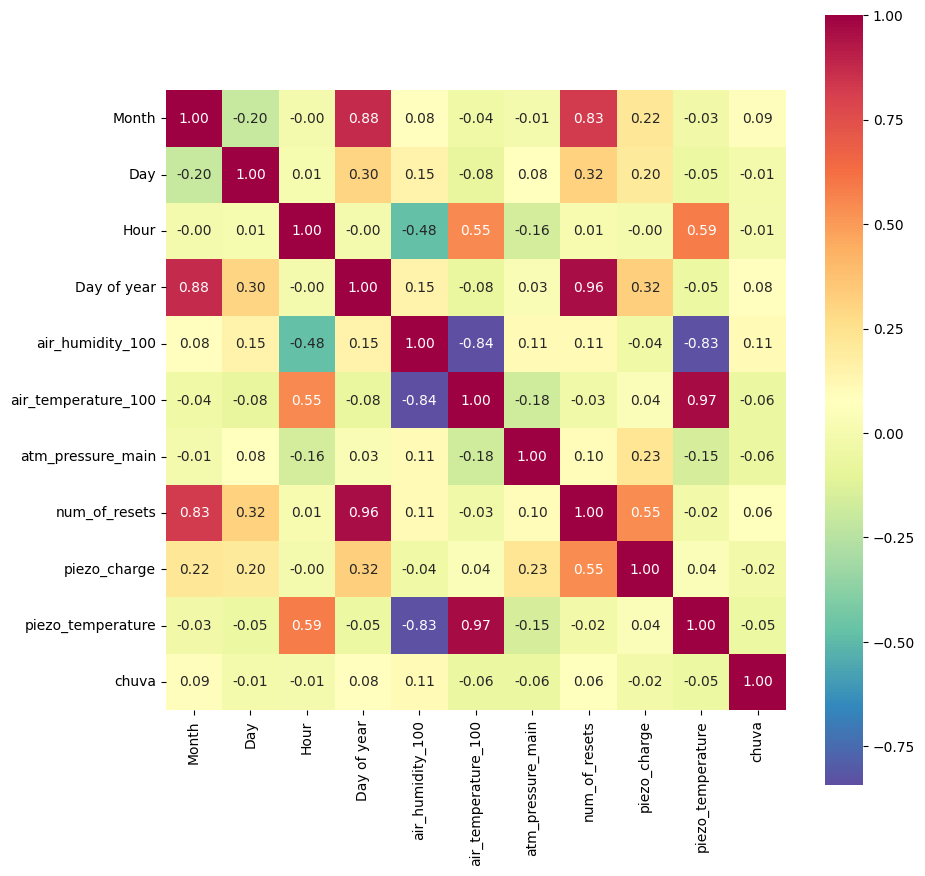

In [448]:
plt.figure(figsize=(10, 10))
sns.heatmap(sensor_merged.iloc[:, 2:].corr(), annot=True, cmap="Spectral_r", fmt='.2f', square=True)
plt.show()

Olhando para a distrubuição da variavel alvo percebemos um grande problema, os dados estão concentrados em um lado somente.  
No melhor dos mundos seria interessante que esses dados estivessem em uma distribuição normal.  
Vamos tentar dar uma melhorada nisso usando uma técnica de transformação dos dados alvos. Apesar de usar essa técnica, a melhora não é muito grande!

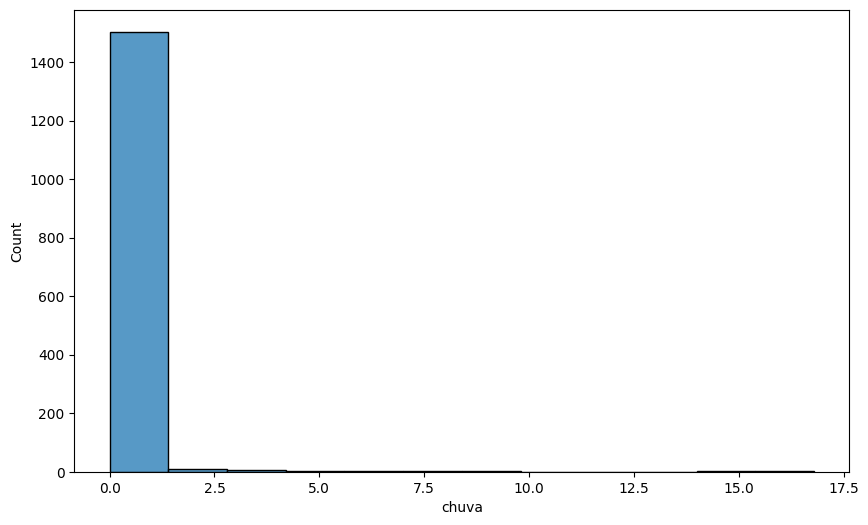

In [449]:
plt.figure(figsize=(10, 6))
sns.histplot(sensor_merged, x="chuva")
plt.show()

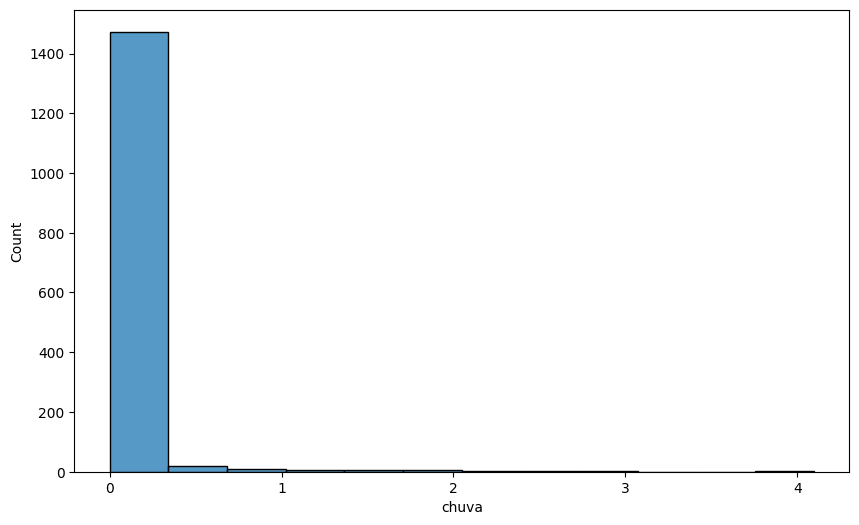

In [450]:
transformer = Transformer()
plt.figure(figsize=(10, 6))
sns.histplot(x=transformer.apply_transformation(sensor_merged["chuva"], "square_root"))
plt.show()

## Criando o modelo

Bora criar nosso modelo!!  
Como tempos um problema de série temporal, temos que ter cuidado até na forma de dividir os dados de treino e os dados de teste!  
Nesse tipo de problema não podemos dividir os dados de forma aleatória, pois o modelo não pode receber dados do futuro enquanto for treinado.  
Depois de dividir é bom dar uma olhada na distribuição dos valores da variavel alvo, se for necessário mais dados devem ser usados para teste ou treino.

In [451]:
X_train_c = sensor_merged[sensor_merged["Day of year"] < 324]
X_test_c = sensor_merged[sensor_merged["Day of year"] >= 324]
X_train_c.shape, X_test_c.shape

((1168, 13), (360, 13))

In [452]:
X_train_c["chuva"].value_counts()

chuva
0.0     1128
0.2        9
0.8        4
0.6        4
0.4        3
1.2        2
2.2        2
9.2        2
16.8       1
6.8        1
2.0        1
3.4        1
4.2        1
3.6        1
1.8        1
2.8        1
2.4        1
5.6        1
3.0        1
1.6        1
4.0        1
6.2        1
Name: count, dtype: int64

In [453]:
X_test_c["chuva"].value_counts()

chuva
0.0     345
0.2       5
3.8       1
4.6       1
1.0       1
1.2       1
0.4       1
15.2      1
8.2       1
6.8       1
1.6       1
0.6       1
Name: count, dtype: int64

In [454]:
X_train = X_train_c.iloc[:, 1:-1]
y_train = X_train_c["chuva"]
X_test = X_test_c.iloc[:, 1:-1]
y_test = X_test_c["chuva"]

In [455]:
colunas_num = X_train.columns

Vamos criar a pipeline do modelo!  
É sempre bom criar a pipeline do modelo, assim ela será responsável por qualquer transformação necessária, diminuindo as chances de erro no momento de criação do modelo, evitando data leakage e outros problemas. Facilitando também futuras alterações no modelo.

In [456]:
def make_pipeline(colunas_num: list, params: dict):
    """
    Método responsável por criar a pipeline do modelo
    
    Parameters:
    colunas_num (list): lista das colunas numéricas

    Returns:
    clf (pipeline): pipeline do modelo
    """
    
    num_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, colunas_num),
        ]
    )

    model = xgb.XGBRegressor(verbosity=1, n_jobs=-1, **params)
    clf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", model)
        ],
        verbose=True
    )
    return clf

é muito importante otimizar o seu modelo, para isso estou usando Optuna. Optuna permite que varias combinações de hiperparametros diferentes sejam usados, validando o resultado do modelo a partir de uma função objetiva. Nesse modelo quero maximizar a métrica r2_score, rodando 300 modelos diferentes e então escolhendo aquele com os melhores parametros.

In [457]:
def objective(trial, colunas_num: list):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': r2_score,
    }
    transformer = Transformer()
    
    y_train_transformed = transformer.apply_transformation(y_train, "square_root")
    clf = make_pipeline(colunas_num=colunas_num, params=params)
    clf.fit(X_train, y_train_transformed)
    y_pred = clf.predict(X_test)
    y_pred = transformer.apply_inverse_transformation(y_pred, "square_root")

    metric = r2_score(y_test, y_pred)
    return metric

In [458]:
func = lambda trial: objective(trial, colunas_num)
study = optuna.create_study(direction='maximize')
study.optimize(func, n_trials=300, n_jobs=-1)
best_params = study.best_trial.params

[I 2023-08-02 20:10:04,606] A new study created in memory with name: no-name-4830a7ec-5eac-4dc2-8e2a-7b57ed83b85c


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipel

[I 2023-08-02 20:10:05,062] Trial 2 finished with value: -0.14638555906763528 and parameters: {'max_depth': 1, 'learning_rate': 0.1443107766897927, 'n_estimators': 181, 'min_child_weight': 5, 'gamma': 0.6051189570641089, 'subsample': 0.4958569540795892, 'colsample_bytree': 0.19571781457721577, 'reg_alpha': 0.8289204839654416, 'reg_lambda': 0.692187233630648}. Best is trial 2 with value: -0.14638555906763528.
[I 2023-08-02 20:10:05,223] Trial 1 finished with value: 0.013336220644021624 and parameters: {'max_depth': 3, 'learning_rate': 0.04137114594533575, 'n_estimators': 192, 'min_child_weight': 7, 'gamma': 0.1493632949363593, 'subsample': 0.5623070266106804, 'colsample_bytree': 0.08585775934276854, 'reg_alpha': 0.08780269110555272, 'reg_lambda': 0.5397866238945184}. Best is trial 1 with value: 0.013336220644021624.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.5s


[I 2023-08-02 20:10:05,277] Trial 11 finished with value: -0.3704384427652938 and parameters: {'max_depth': 1, 'learning_rate': 0.632358495876167, 'n_estimators': 303, 'min_child_weight': 5, 'gamma': 0.18357984657720788, 'subsample': 0.350504139167515, 'colsample_bytree': 0.3595434294908666, 'reg_alpha': 0.37084017667316965, 'reg_lambda': 0.982860890252167}. Best is trial 1 with value: 0.013336220644021624.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:05,512] Trial 13 finished with value: -0.11031195643278102 and parameters: {'max_depth': 2, 'learning_rate': 0.5712970768926794, 'n_estimators': 323, 'min_child_weight': 2, 'gamma': 0.2048438605686666, 'subsample': 0.9714237717289577, 'colsample_bytree': 0.6289370819759618, 'reg_alpha': 0.25146649633567936, 'reg_lambda': 0.1867878058364079}. Best is trial 1 with value: 0.013336220644021624.
[I 2023-08-02 20:10:05,539] Trial 8 finished with value: -1.003263097469807 and parameters: {'max_depth': 6, 'learning_rate': 0.1575082457740521, 'n_estimators': 130, 'min_child_weight': 4, 'gamma': 0.13098029330862573, 'subsample': 0.7734456052830174, 'colsample_bytree': 0.6640324446293738, 'reg_alpha': 0.5859392556549172, 'reg_lambda': 0.6476888684425981}. Best is trial 1 with value: 0.013336220644021624.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:05,836] Trial 0 finished with value: -0.11531972371698451 and parameters: {'max_depth': 7, 'learning_rate': 0.2867568875083951, 'n_estimators': 206, 'min_child_weight': 4, 'gamma': 0.004997394985962535, 'subsample': 0.3803666658166341, 'colsample_bytree': 0.5406732443450448, 'reg_alpha': 0.6853828882298288, 'reg_lambda': 0.690164593967795}. Best is trial 1 with value: 0.013336220644021624.
[I 2023-08-02 20:10:05,935] Trial 14 finished with value: -1.7689769045968404 and parameters: {'max_depth': 6, 'learning_rate': 0.28262799942340366, 'n_estimators': 215, 'min_child_weight': 8, 'gamma': 0.2756771301226713, 'subsample': 0.9856455685164892, 'colsample_bytree': 0.818115830827388, 'reg_alpha': 0.2517505208082814, 'reg_lambda': 0.7385323582217642}. Best is trial 1 with value: 0.013336220644021624.
[I 2023-08-02 20:10:05,989] Trial 3 finished with value: -0.02011893730520109 and parameters: {'max_depth': 4, 'learning_rate': 0.8290805614474812, 'n_estimators': 396, 'min_c

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:06,172] Trial 9 finished with value: -3.38746461807224 and parameters: {'max_depth': 3, 'learning_rate': 0.9180183182872287, 'n_estimators': 472, 'min_child_weight': 1, 'gamma': 0.35031169525768907, 'subsample': 0.9705009131877809, 'colsample_bytree': 0.40888659944745903, 'reg_alpha': 0.7497618929138609, 'reg_lambda': 0.5597340399081209}. Best is trial 1 with value: 0.013336220644021624.
[I 2023-08-02 20:10:06,217] Trial 20 finished with value: -4.876306355195766 and parameters: {'max_depth': 5, 'learning_rate': 0.9314582830425087, 'n_estimators': 210, 'min_child_weight': 5, 'gamma': 0.43211535427404046, 'subsample': 0.07069856815891755, 'colsample_bytree': 0.07821756481537731, 'reg_alpha': 0.39467898538995283, 'reg_lambda': 0.9543158047423583}. Best is trial 1 with value: 0.013336220644021624.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:06,374] Trial 22 finished with value: -0.07740706423891974 and parameters: {'max_depth': 3, 'learning_rate': 0.33550949243441375, 'n_estimators': 106, 'min_child_weight': 6, 'gamma': 0.9366900769475015, 'subsample': 0.905045145321079, 'colsample_bytree': 0.05937584734993427, 'reg_alpha': 0.31110059179346794, 'reg_lambda': 0.8525705886061385}. Best is trial 1 with value: 0.013336220644021624.
[I 2023-08-02 20:10:06,500] Trial 16 finished with value: -0.2080780815207901 and parameters: {'max_depth': 7, 'learning_rate': 0.8071477368540341, 'n_estimators': 297, 'min_child_weight': 5, 'gamma': 0.07555298943617794, 'subsample': 0.5570761169817102, 'colsample_bytree': 0.15638091796367048, 'reg_alpha': 0.08970190812078756, 'reg_lambda': 0.004379004101168074}. Best is trial 1 with value: 0.013336220644021624.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:06,694] Trial 12 finished with value: -0.11186474009334879 and parameters: {'max_depth': 7, 'learning_rate': 0.4232252569955475, 'n_estimators': 384, 'min_child_weight': 9, 'gamma': 0.6016826411249041, 'subsample': 0.8392093172500531, 'colsample_bytree': 0.08422320506512586, 'reg_alpha': 0.02900485300966033, 'reg_lambda': 0.8303261025634502}. Best is trial 1 with value: 0.013336220644021624.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:06,892] Trial 25 finished with value: -0.0003290246562970278 and parameters: {'max_depth': 9, 'learning_rate': 0.01401893111001741, 'n_estimators': 62, 'min_child_weight': 10, 'gamma': 0.8299588701568749, 'subsample': 0.655748936154699, 'colsample_bytree': 0.029736964539862902, 'reg_alpha': 0.016685017483928033, 'reg_lambda': 0.3861314736255176}. Best is trial 1 with value: 0.013336220644021624.
[I 2023-08-02 20:10:06,897] Trial 5 finished with value: -7.085296888447383 and parameters: {'max_depth': 6, 'learning_rate': 0.8488461571355094, 'n_estimators': 400, 'min_child_weight': 6, 'gamma': 0.9801119306880903, 'subsample': 0.11124846981115578, 'colsample_bytree': 0.660959552608839, 'reg_alpha': 0.8609320741449931, 'reg_lambda': 0.5968982862227402}. Best is trial 1 with value: 0.013336220644021624.
[I 2023-08-02 20:10:07,083] Trial 19 finished with value: 0.07451220268609815 and parameters: {'max_depth': 7, 'learning_rate': 0.38283367503827037, 'n_estimators': 214, '

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.5s


[I 2023-08-02 20:10:07,264] Trial 4 finished with value: -6.5832867647805555 and parameters: {'max_depth': 5, 'learning_rate': 0.897652933755252, 'n_estimators': 439, 'min_child_weight': 1, 'gamma': 0.4230102759946786, 'subsample': 0.9163199297145422, 'colsample_bytree': 0.4526640066041995, 'reg_alpha': 0.7406124636611885, 'reg_lambda': 0.02329923934204531}. Best is trial 19 with value: 0.07451220268609815.
[I 2023-08-02 20:10:07,334] Trial 28 finished with value: 0.008715683266895535 and parameters: {'max_depth': 9, 'learning_rate': 0.042894539211427364, 'n_estimators': 50, 'min_child_weight': 7, 'gamma': 0.024031775782837578, 'subsample': 0.7164292210511098, 'colsample_bytree': 0.28525803141042033, 'reg_alpha': 0.9951529964025561, 'reg_lambda': 0.45250039983954127}. Best is trial 19 with value: 0.07451220268609815.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:07,639] Trial 30 finished with value: 0.00011752446537449668 and parameters: {'max_depth': 9, 'learning_rate': 0.014155421111898051, 'n_estimators': 54, 'min_child_weight': 10, 'gamma': 0.7894573543412883, 'subsample': 0.6697134057193002, 'colsample_bytree': 0.03668615851007275, 'reg_alpha': 0.11908355247553815, 'reg_lambda': 0.4013442699183073}. Best is trial 19 with value: 0.07451220268609815.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.6s


[I 2023-08-02 20:10:07,776] Trial 24 finished with value: -0.015785908956143846 and parameters: {'max_depth': 8, 'learning_rate': 0.6824490528641352, 'n_estimators': 167, 'min_child_weight': 9, 'gamma': 0.7989074106056839, 'subsample': 0.2903208992893603, 'colsample_bytree': 0.11499304289816954, 'reg_alpha': 0.8714953750781096, 'reg_lambda': 0.23886179568612168}. Best is trial 19 with value: 0.07451220268609815.
[I 2023-08-02 20:10:07,957] Trial 29 finished with value: 0.011439530601222825 and parameters: {'max_depth': 9, 'learning_rate': 0.037533193758623656, 'n_estimators': 74, 'min_child_weight': 10, 'gamma': 0.7731203250398024, 'subsample': 0.6629764275273757, 'colsample_bytree': 0.266604946134895, 'reg_alpha': 0.009905453626338573, 'reg_lambda': 0.421252688369075}. Best is trial 19 with value: 0.07451220268609815.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s


[I 2023-08-02 20:10:07,964] Trial 17 finished with value: -0.19757579240813317 and parameters: {'max_depth': 8, 'learning_rate': 0.39117414346301355, 'n_estimators': 346, 'min_child_weight': 3, 'gamma': 0.4608609464038723, 'subsample': 0.14236807360703943, 'colsample_bytree': 0.3190278524184133, 'reg_alpha': 0.8266667246221083, 'reg_lambda': 0.36552726688297993}. Best is trial 19 with value: 0.07451220268609815.
[I 2023-08-02 20:10:08,188] Trial 6 finished with value: 0.07729124582345692 and parameters: {'max_depth': 7, 'learning_rate': 0.14713548340026036, 'n_estimators': 408, 'min_child_weight': 10, 'gamma': 0.9676569712714836, 'subsample': 0.6987827041353047, 'colsample_bytree': 0.3943521032722139, 'reg_alpha': 0.12456023104082115, 'reg_lambda': 0.4547084510994935}. Best is trial 6 with value: 0.07729124582345692.
[I 2023-08-02 20:10:08,255] Trial 10 finished with value: -1.8657335869167766 and parameters: {'max_depth': 7, 'learning_rate': 0.5813891647057718, 'n_estimators': 416, 'm

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:08,381] Trial 21 finished with value: -0.0072772490626451525 and parameters: {'max_depth': 8, 'learning_rate': 0.6131540820480601, 'n_estimators': 277, 'min_child_weight': 10, 'gamma': 0.5461567212319225, 'subsample': 0.13848104043748316, 'colsample_bytree': 0.3269692317171635, 'reg_alpha': 0.9066316530881093, 'reg_lambda': 0.07298975113577155}. Best is trial 6 with value: 0.07729124582345692.
[I 2023-08-02 20:10:08,420] Trial 18 finished with value: -0.05781512755774765 and parameters: {'max_depth': 7, 'learning_rate': 0.7712415347319083, 'n_estimators': 345, 'min_child_weight': 7, 'gamma': 0.84029403331387, 'subsample': 0.7216818796429801, 'colsample_bytree': 0.43915682156980446, 'reg_alpha': 0.9028277618283094, 'reg_lambda': 0.5965034188591796}. Best is trial 6 with value: 0.07729124582345692.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:09,012] Trial 7 finished with value: -1.2803755673394126 and parameters: {'max_depth': 7, 'learning_rate': 0.7216603726418687, 'n_estimators': 467, 'min_child_weight': 8, 'gamma': 0.5198764332966467, 'subsample': 0.7271723937106407, 'colsample_bytree': 0.7060848905583024, 'reg_alpha': 0.6236759117306498, 'reg_lambda': 0.6108912893801187}. Best is trial 6 with value: 0.07729124582345692.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   4.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:09,294] Trial 34 finished with value: 0.036563016836343776 and parameters: {'max_depth': 4, 'learning_rate': 0.4649907929363313, 'n_estimators': 241, 'min_child_weight': 8, 'gamma': 0.2862157652597713, 'subsample': 0.8106329808607725, 'colsample_bytree': 0.20455455211080378, 'reg_alpha': 0.17656994990022423, 'reg_lambda': 0.2797985776996443}. Best is trial 6 with value: 0.07729124582345692.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:09,516] Trial 35 finished with value: 0.0401795420365747 and parameters: {'max_depth': 4, 'learning_rate': 0.4311330650658924, 'n_estimators': 254, 'min_child_weight': 8, 'gamma': 0.2992635161489503, 'subsample': 0.5773121783800964, 'colsample_bytree': 0.20791500071254893, 'reg_alpha': 0.18017782288690148, 'reg_lambda': 0.5370780591635872}. Best is trial 6 with value: 0.07729124582345692.
[I 2023-08-02 20:10:09,606] Trial 26 finished with value: 0.03231154267682379 and parameters: {'max_depth': 4, 'learning_rate': 0.023468804910166285, 'n_estimators': 424, 'min_child_weight': 10, 'gamma': 0.01316608968953753, 'subsample': 0.6856268983322068, 'colsample_bytree': 0.2644447280927641, 'reg_alpha': 0.0018980838467144712, 'reg_lambda': 0.4054318195321024}. Best is trial 6 with value: 0.07729124582345692.
[I 2023-08-02 20:10:09,616] Trial 15 finished with value: -1.89416476006926 and parameters: {'max_depth': 8, 'learning_rate': 0.7051176483334322, 'n_estimators': 494, 'mi

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   4.8s


[I 2023-08-02 20:10:09,795] Trial 33 finished with value: 0.11806764868089048 and parameters: {'max_depth': 8, 'learning_rate': 0.45587890477928045, 'n_estimators': 250, 'min_child_weight': 8, 'gamma': 0.3129898267115988, 'subsample': 0.6079877183869555, 'colsample_bytree': 0.1970106787516112, 'reg_alpha': 0.15653272812213712, 'reg_lambda': 0.36095753939636854}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:09,922] Trial 23 finished with value: -1.633319296046008 and parameters: {'max_depth': 8, 'learning_rate': 0.8119987159874884, 'n_estimators': 387, 'min_child_weight': 2, 'gamma': 0.1635757567726611, 'subsample': 0.5883657863092807, 'colsample_bytree': 0.3462064821730938, 'reg_alpha': 0.6126172346324935, 'reg_lambda': 0.9435384822484421}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.9s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s


[I 2023-08-02 20:10:09,978] Trial 31 finished with value: -0.08061594896796542 and parameters: {'max_depth': 9, 'learning_rate': 0.4610608810554095, 'n_estimators': 247, 'min_child_weight': 8, 'gamma': 0.34535946196420286, 'subsample': 0.7727975541429019, 'colsample_bytree': 0.2772838900080583, 'reg_alpha': 0.10432264473572832, 'reg_lambda': 0.45223258422695833}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:10,102] Trial 41 finished with value: 0.050908265559455046 and parameters: {'max_depth': 3, 'learning_rate': 0.1807680305141689, 'n_estimators': 240, 'min_child_weight': 8, 'gamma': 0.29079390651859427, 'subsample': 0.5810616167743649, 'colsample_bytree': 0.2000172457010257, 'reg_alpha': 0.1642240420670486, 'reg_lambda': 0.301675561524696}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:10,223] Trial 32 finished with value: -0.1559032750705176 and parameters: {'max_depth': 9, 'learning_rate': 0.49049221638036056, 'n_estimators': 261, '

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s


[I 2023-08-02 20:10:10,374] Trial 39 finished with value: 0.08749722778073976 and parameters: {'max_depth': 4, 'learning_rate': 0.16984448915303155, 'n_estimators': 252, 'min_child_weight': 8, 'gamma': 0.29420065778448923, 'subsample': 0.5529890072733407, 'colsample_bytree': 0.18635544763917958, 'reg_alpha': 0.15273270748175105, 'reg_lambda': 0.5370049606182374}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:10,387] Trial 27 finished with value: -0.004792570166310739 and parameters: {'max_depth': 9, 'learning_rate': 0.015180553324624403, 'n_estimators': 408, 'min_child_weight': 10, 'gamma': 0.029337690829605162, 'subsample': 0.7016449939230063, 'colsample_bytree': 0.3006435691086874, 'reg_alpha': 0.8803399370828254, 'reg_lambda': 0.4350816712262264}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:10,571] Trial 40 finished with value: 0.04390477719985342 and parameters: {'max_depth': 4, 'learning_rate': 0.18476260695553504, 'n_estimators': 251, 'min_child_weight': 8, 'gamma': 0.3255493490969566, 'subsample': 0.5771714551280843, 'colsample_bytree': 0.19370180319138777, 'reg_alpha': 0.1484942544993043, 'reg_lambda': 0.29733750733811515}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:10,687] Trial 38 finished with value: 0.04639921955953186 and parameters: {'max_depth': 4, 'learning_rate': 0.19485617694230922, 'n_estimators': 272, 'min_child_weight': 8, 'gamma': 0.3091256365234048, 'subsample': 0.5578970921170012, 'colsample_bytree': 0.20582982711082207, 'reg_alpha': 0.16331804526913285, 'reg_lambda': 0.5590456057058566}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.9s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s


[I 2023-08-02 20:10:10,775] Trial 37 finished with value: 0.07786017281795488 and parameters: {'max_depth': 8, 'learning_rate': 0.17268967719485656, 'n_estimators': 259, 'min_child_weight': 8, 'gamma': 0.2898904364742135, 'subsample': 0.5350932601121151, 'colsample_bytree': 0.21626287582102896, 'reg_alpha': 0.15611427488652735, 'reg_lambda': 0.5441258636794432}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:10,777] Trial 36 finished with value: 0.06256283387030115 and parameters: {'max_depth': 8, 'learning_rate': 0.18222801197739347, 'n_estimators': 259, 'min_child_weight': 8, 'gamma': 0.3174700390947725, 'subsample': 0.5618647445276589, 'colsample_bytree': 0.20992324413365576, 'reg_alpha': 0.15722814412059344, 'reg_lambda': 0.5159054129806453}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:11,242] Trial 42 finished with value: 0.019624000137316577 and parameters: {'max_depth': 4, 'learning_rate': 0.17995654747563028, 'n_estimators': 243, 'min_child_weight': 8, 'gamma': 0.28647349884399453, 'subsample': 0.5731711439575705, 'colsample_bytree': 0.19577869626749922, 'reg_alpha': 0.16144168312797824, 'reg_lambda': 0.29410640647403136}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:11,885] Trial 43 finished with value: 0.017646832729324213 and parameters: {'max_depth': 5, 'learning_rate': 0.5082230116866329, 'n_estimators': 249, 'min_child_weight': 9, 'gamma': 0.3317669586605987, 'subsample': 0.7840361538084569, 'colsample_bytree': 0.19728981200186288, 'reg_alpha': 0.17302464685549368, 'reg_lambda': 0.3024410165250688}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s


[I 2023-08-02 20:10:12,168] Trial 44 finished with value: -0.2748397110022145 and parameters: {'max_depth': 4, 'learning_rate': 0.5116626525943411, 'n_estimators': 230, 'min_child_weight': 9, 'gamma': 0.34409434063066185, 'subsample': 0.6047941155329009, 'colsample_bytree': 0.5150870238471084, 'reg_alpha': 0.1551804619051002, 'reg_lambda': 0.48365510844122206}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:12,331] Trial 46 finished with value: 0.013891182103814126 and parameters: {'max_depth': 4, 'learning_rate': 0.4721665478943796, 'n_estimators': 240, 'min_child_weight': 9, 'gamma': 0.3199387204250616, 'subsample': 0.7953989907800612, 'colsample_bytree': 0.18931484784346664, 'reg_alpha': 0.17258369621122088, 'reg_lambda': 0.3238141221499132}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:12,429] Trial 51 finished with value: 0.016026315045467032 and parameters: {'max_depth': 6, 'learning_rate': 0.2843485787240646, 'n_estimators': 160, 'min_child_weight': 9, 'gamma': 0.6808034362701552, 'subsample': 0.48005267334270196, 'colsample_bytree': 0.15410597154620728, 'reg_alpha': 0.1316925701571323, 'reg_lambda': 0.3223774873364969}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.9s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:12,580] Trial 53 finished with value: 0.01711872977666784 and parameters: {'max_depth': 5, 'learning_rate': 0.23430090713320512, 'n_estimators': 172, 'min_child_weight': 9, 'gamma': 0.39406362042725734, 'subsample': 0.46404739316681276, 'colsample_bytree': 0.13733418101449396, 'reg_alpha': 0.06545156377259151, 'reg_lambda': 0.5091933811628505}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:12,659] Trial 45 finished with value: -0.050457709335401946 and parameters: {'max_depth': 6, 'learning_rate': 0.5184895096133146, 'n_estimators': 237, 'min_child_weight': 9, 'gamma': 0.3648792652218211, 'subsample': 0.6017581467028087, 'colsample_bytree': 0.5167911580489842, 'reg_alpha': 0.172053740794415, 'reg_lambda': 0.483146125245781}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:12,690] Trial 50 finished with value: 0.027657876276671156 and parameters: {'max_depth': 6, 'learning_rate': 0.24666627508057976, 'n_estimators': 194, 

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s


[I 2023-08-02 20:10:12,873] Trial 52 finished with value: 0.027352948543241107 and parameters: {'max_depth': 5, 'learning_rate': 0.25141361324418177, 'n_estimators': 159, 'min_child_weight': 9, 'gamma': 0.38840134724562814, 'subsample': 0.4736270282825169, 'colsample_bytree': 0.5400152587103568, 'reg_alpha': 0.07001919406646147, 'reg_lambda': 0.4972982624062627}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:13,024] Trial 57 finished with value: 0.004451265993096976 and parameters: {'max_depth': 5, 'learning_rate': 0.26070460244611365, 'n_estimators': 178, 'min_child_weight': 9, 'gamma': 0.38231948259286674, 'subsample': 0.4923768376589159, 'colsample_bytree': 0.12929530340935372, 'reg_alpha': 0.06774306912254664, 'reg_lambda': 0.6770178529721314}. Best is trial 33 with value: 0.11806764868089048.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s


[I 2023-08-02 20:10:13,036] Trial 58 finished with value: 0.017114664991078943 and parameters: {'max_depth': 6, 'learning_rate': 0.2573284474728277, 'n_estimators': 172, 'min_child_weight': 9, 'gamma': 0.2358280095460477, 'subsample': 0.48046399467490475, 'colsample_bytree': 0.14636953241798473, 'reg_alpha': 0.06653333607005557, 'reg_lambda': 0.4730319125758499}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:13,120] Trial 56 finished with value: 0.010418186531071516 and parameters: {'max_depth': 5, 'learning_rate': 0.2529431605611623, 'n_estimators': 189, 'min_child_weight': 9, 'gamma': 0.3840043635751208, 'subsample': 0.47900394365937277, 'colsample_bytree': 0.14514660747643915, 'reg_alpha': 0.06575611067582207, 'reg_lambda': 0.6724375818805844}. Best is trial 33 with value: 0.11806764868089048.
[I 2023-08-02 20:10:13,160] Trial 54 finished with value: 0.05485350962064206 and parameters: {'max_depth': 6, 'learning_rate': 0.27180044013054483, 'n_estimators': 156

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s


[I 2023-08-02 20:10:13,314] Trial 48 finished with value: 0.1209357471729009 and parameters: {'max_depth': 6, 'learning_rate': 0.4947561740652827, 'n_estimators': 244, 'min_child_weight': 9, 'gamma': 0.35209617966496615, 'subsample': 0.4642576827114189, 'colsample_bytree': 0.18565862613909753, 'reg_alpha': 0.15703664648340154, 'reg_lambda': 0.49208194166109176}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:13,363] Trial 55 finished with value: 0.034043985412974154 and parameters: {'max_depth': 5, 'learning_rate': 0.2574004894611258, 'n_estimators': 171, 'min_child_weight': 9, 'gamma': 0.400457997452749, 'subsample': 0.47405606995221994, 'colsample_bytree': 0.515168546529095, 'reg_alpha': 0.07269840389191647, 'reg_lambda': 0.16435657037474682}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:10:13,499] Trial 49 finished with value: 0.11454828548295992 and parameters: {'max_depth': 6, 'learning_rate': 0.2834766395706887, 'n_estimators': 244, 'min_child_weight': 9, 'gamma': 0.6937638001576096, 'subsample': 0.5899005136288682, 'colsample_bytree': 0.2051105787708892, 'reg_alpha': 0.1686012647169434, 'reg_lambda': 0.5218418751763172}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s


[I 2023-08-02 20:10:13,995] Trial 59 finished with value: 0.00909834287676492 and parameters: {'max_depth': 6, 'learning_rate': 0.25278564209207516, 'n_estimators': 196, 'min_child_weight': 9, 'gamma': 0.38403324989580223, 'subsample': 0.49918643327152695, 'colsample_bytree': 0.1373837183750981, 'reg_alpha': 0.06670261666815021, 'reg_lambda': 0.4804358628280173}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:14,564] Trial 60 finished with value: -0.009012657828876058 and parameters: {'max_depth': 6, 'learning_rate': 0.2525091430113968, 'n_estimators': 174, 'min_child_weight': 7, 'gamma': 0.2453429908160433, 'subsample': 0.4996521022295424, 'colsample_bytree': 0.12071217418626325, 'reg_alpha': 0.06409688618254548, 'reg_lambda': 0.645451186630582}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:14,864] Trial 61 finished with value: 9.580930305275182e-05 and parameters: {'max_depth': 6, 'learning_rate': 0.27560091702803546, 'n_estimators': 169, 'min_child_weight': 7, 'gamma': 0.3941172768059242, 'subsample': 0.5043591947720145, 'colsample_bytree': 0.14548101808150649, 'reg_alpha': 0.06292158307033605, 'reg_lambda': 0.6493320314317058}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:15,089] Trial 62 finished with value: -0.026096645434456223 and parameters: {'max_depth': 6, 'learning_rate': 0.1098781050277653, 'n_estimators': 195, 'min_child_weight': 7, 'gamma': 0.2189872251452406, 'subsample': 0.4911429996856828, 'colsample_bytree': 0.37044733360027554, 'reg_alpha': 0.07040823643569147, 'reg_lambda': 0.4761700832746086}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s


[I 2023-08-02 20:10:15,402] Trial 63 finished with value: 0.054414379315305794 and parameters: {'max_depth': 6, 'learning_rate': 0.09994599914494391, 'n_estimators': 190, 'min_child_weight': 7, 'gamma': 0.3960865458434778, 'subsample': 0.6269739333405586, 'colsample_bytree': 0.40718990033454155, 'reg_alpha': 0.06684306741775928, 'reg_lambda': 0.6621219359007715}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:15,932] Trial 65 finished with value: 0.020778397618890665 and parameters: {'max_depth': 7, 'learning_rate': 0.09843540591852856, 'n_estimators': 290, 'min_child_weight': 7, 'gamma': 0.25376445220392496, 'subsample': 0.5211692326543303, 'colsample_bytree': 0.38228751281816575, 'reg_alpha': 0.05646506725662817, 'reg_lambda': 0.6351234940540913}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:16,136] Trial 74 finished with value: -0.13887414378900687 and parameters: {'max_depth': 7, 'learning_rate': 0.34397579671184886, 'n_estimators': 292, 'min_child_weight': 7, 'gamma': 0.24648079495331676, 'subsample': 0.5305328646376579, 'colsample_bytree': 0.09577667777257351, 'reg_alpha': 0.23822222404582222, 'reg_lambda': 0.5634595120341371}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:16,177] Trial 75 finished with value: -0.073715282171392 and parameters: {'max_depth': 7, 'learning_rate': 0.3505461047756747, 'n_estimators': 298, 'min_child_weight': 7, 'gamma': 0.24689190947584974, 'subsample': 0.5220374524570225, 'colsample_bytree': 0.09734980787990492, 'reg_alpha': 0.24030551158047167, 'reg_lambda': 0.5776599796316799}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:16,303] Trial 64 finished with value: 0.0003772759166550399 and parameters: {'max_depth': 7, 'learning_rate': 0.0834974388879595, 'n_estimators': 305

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s


[I 2023-08-02 20:10:16,480] Trial 66 finished with value: 0.013283874543077112 and parameters: {'max_depth': 7, 'learning_rate': 0.11674331769345807, 'n_estimators': 298, 'min_child_weight': 7, 'gamma': 0.2426283807149725, 'subsample': 0.518639035478213, 'colsample_bytree': 0.3975903612884482, 'reg_alpha': 0.23569498358357202, 'reg_lambda': 0.6586125823897733}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:16,482] Trial 77 finished with value: -0.03325632835178771 and parameters: {'max_depth': 7, 'learning_rate': 0.12394478662602759, 'n_estimators': 297, 'min_child_weight': 7, 'gamma': 0.44710438649270545, 'subsample': 0.6426821235519256, 'colsample_bytree': 0.09106886022442609, 'reg_alpha': 0.21999023841391108, 'reg_lambda': 0.5744809930364331}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:16,757] Trial 67 finished with value: 0.045023732845214215 and parameters: {'max_depth': 7, 'learning_rate': 0.10918293066845504, 'n_estimators': 300, 'min_child_weight': 7, 'gamma': 0.2372843790989833, 'subsample': 0.5302876702184226, 'colsample_bytree': 0.38128350148078527, 'reg_alpha': 0.2182706912194063, 'reg_lambda': 0.6413813782906774}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:16,763] Trial 68 finished with value: 0.09051527282085714 and parameters: {'max_depth': 7, 'learning_rate': 0.11213674745619784, 'n_estimators': 295, 'min_child_weight': 7, 'gamma': 0.2377640259296266, 'subsample': 0.6168330192219869, 'colsample_bytree': 0.39081239476473945, 'reg_alpha': 0.2757049112971605, 'reg_lambda': 0.6339013126175337}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:16,797] Trial 69 finished with value: -0.0888932096822761 and parameters: {'max_depth': 7, 'learning_rate': 0.3580255677304208, 'n_estimators': 296, 'm

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:10:16,897] Trial 73 finished with value: 0.09529647833642463 and parameters: {'max_depth': 7, 'learning_rate': 0.1257977043072402, 'n_estimators': 299, 'min_child_weight': 6, 'gamma': 0.24584246120231376, 'subsample': 0.5185577677454408, 'colsample_bytree': 0.38122521510188934, 'reg_alpha': 0.2822715883268282, 'reg_lambda': 0.6245072985880007}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:17,032] Trial 70 finished with value: -0.27306009559041033 and parameters: {'max_depth': 7, 'learning_rate': 0.33131235278265764, 'n_estimators': 298, 'min_child_weight': 7, 'gamma': 0.24167038083590756, 'subsample': 0.6381508601646276, 'colsample_bytree': 0.4040428358989258, 'reg_alpha': 0.22048255894484856, 'reg_lambda': 0.5683342258296116}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s


[I 2023-08-02 20:10:17,320] Trial 76 finished with value: 0.12706894490199783 and parameters: {'max_depth': 7, 'learning_rate': 0.11751500054521469, 'n_estimators': 296, 'min_child_weight': 7, 'gamma': 0.24703767776700392, 'subsample': 0.634080964258333, 'colsample_bytree': 0.3878807688049479, 'reg_alpha': 0.28649459871897626, 'reg_lambda': 0.5719440333716418}. Best is trial 47 with value: 0.15034497797577884.
[I 2023-08-02 20:10:17,421] Trial 78 finished with value: 0.1245909472170923 and parameters: {'max_depth': 7, 'learning_rate': 0.33835280057232064, 'n_estimators': 295, 'min_child_weight': 10, 'gamma': 0.4741158678519571, 'subsample': 0.6263633997454849, 'colsample_bytree': 0.23072346318089323, 'reg_alpha': 0.2141838193081094, 'reg_lambda': 0.5731038278614947}. Best is trial 47 with value: 0.15034497797577884.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:17,952] Trial 79 finished with value: 0.1546023894563402 and parameters: {'max_depth': 7, 'learning_rate': 0.3232535467685749, 'n_estimators': 290, 'min_child_weight': 10, 'gamma': 0.48479213723161607, 'subsample': 0.5351169743062555, 'colsample_bytree': 0.2376025389880256, 'reg_alpha': 0.22087505854160316, 'reg_lambda': 0.5689742264677775}. Best is trial 79 with value: 0.1546023894563402.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:18,727] Trial 82 finished with value: 0.024882379121783815 and parameters: {'max_depth': 7, 'learning_rate': 0.307554862750635, 'n_estimators': 221, 'min_child_weight': 10, 'gamma': 0.45733379410807234, 'subsample': 0.43130168174387346, 'colsample_bytree': 0.2454568969711865, 'reg_alpha': 0.20596275493159644, 'reg_lambda': 0.5378618481642735}. Best is trial 79 with value: 0.1546023894563402.
[I 2023-08-02 20:10:18,850] Trial 80 finished with value: 0.0772650794896752 and parameters: {'max_depth': 7, 'learning_rate': 0.32434517208326236, 'n_estimators': 311, 'min_child_weight': 10, 'gamma': 0.4847457656321291, 'subsample': 0.6307108796798109, 'colsample_bytree': 0.2674181439928735, 'reg_alpha': 0.2194118849973159, 'reg_lambda': 0.5728106543411834}. Best is trial 79 with value: 0.1546023894563402.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s


[I 2023-08-02 20:10:19,116] Trial 83 finished with value: -0.02541939973289664 and parameters: {'max_depth': 2, 'learning_rate': 0.548283070462203, 'n_estimators': 331, 'min_child_weight': 10, 'gamma': 0.4667454401185555, 'subsample': 0.6188127794900007, 'colsample_bytree': 0.23745321819601928, 'reg_alpha': 0.20807789920588438, 'reg_lambda': 0.5361224524501015}. Best is trial 79 with value: 0.1546023894563402.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.7s


[I 2023-08-02 20:10:19,333] Trial 81 finished with value: 0.1448220475714872 and parameters: {'max_depth': 7, 'learning_rate': 0.545273926691805, 'n_estimators': 317, 'min_child_weight': 10, 'gamma': 0.45944887644635996, 'subsample': 0.6531684165366813, 'colsample_bytree': 0.2414437750027137, 'reg_alpha': 0.21154805917106162, 'reg_lambda': 0.586691626196031}. Best is trial 79 with value: 0.1546023894563402.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s


[I 2023-08-02 20:10:19,727] Trial 86 finished with value: 0.05450219163453762 and parameters: {'max_depth': 8, 'learning_rate': 0.21116138993716738, 'n_estimators': 221, 'min_child_weight': 10, 'gamma': 0.17617578339336185, 'subsample': 0.6241694884792557, 'colsample_bytree': 0.23109847183709706, 'reg_alpha': 0.10886170164855247, 'reg_lambda': 0.6065791860541663}. Best is trial 79 with value: 0.1546023894563402.
[I 2023-08-02 20:10:20,041] Trial 85 finished with value: 0.04291296882786666 and parameters: {'max_depth': 8, 'learning_rate': 0.15365931581450237, 'n_estimators': 327, 'min_child_weight': 10, 'gamma': 0.48058834327585337, 'subsample': 0.42928831202780177, 'colsample_bytree': 0.2445603373717849, 'reg_alpha': 0.11022218317034253, 'reg_lambda': 0.3745845195927656}. Best is trial 79 with value: 0.1546023894563402.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:20,172] Trial 84 finished with value: 0.07391207811687728 and parameters: {'max_depth': 8, 'learning_rate': 0.1533138673641826, 'n_estimators': 322, 'min_child_weight': 10, 'gamma': 0.9995818498212907, 'subsample': 0.6240522284984003, 'colsample_bytree': 0.23741884462340468, 'reg_alpha': 0.1037677250629837, 'reg_lambda': 0.5296557232478134}. Best is trial 79 with value: 0.1546023894563402.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:20,473] Trial 90 finished with value: 0.04337263813562697 and parameters: {'max_depth': 8, 'learning_rate': 0.21127110974298108, 'n_estimators': 339, 'min_child_weight': 10, 'gamma': 0.19099358470969782, 'subsample': 0.680376844292216, 'colsample_bytree': 0.2516753780149264, 'reg_alpha': 0.09691627038177383, 'reg_lambda': 0.527369081626545}. Best is trial 79 with value: 0.1546023894563402.
[I 2023-08-02 20:10:20,474] Trial 92 finished with value: 0.05620648214445101 and parameters: {'max_depth': 8, 'learning_rate': 0.145018631980109, 'n_estimators': 321, 'min_child_weight': 6, 'gamma': 0.18913761711705598, 'subsample': 0.4305933172461358, 'colsample_bytree': 0.23998946008801525, 'reg_alpha': 0.27467969965582406, 'reg_lambda': 0.5274583446545058}. Best is trial 79 with value: 0.1546023894563402.
[I 2023-08-02 20:10:20,587] Trial 91 finished with value: 0.1423169071915693 and parameters: {'max_depth': 8, 'learning_rate': 0.15095169584824633, 'n_estimators': 330, 'min_

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:20,589] Trial 87 finished with value: 0.04692006895331202 and parameters: {'max_depth': 8, 'learning_rate': 0.31514223549540044, 'n_estimators': 324, 'min_child_weight': 10, 'gamma': 0.47108165820915526, 'subsample': 0.6891280483612885, 'colsample_bytree': 0.2753782917590505, 'reg_alpha': 0.12280036522162269, 'reg_lambda': 0.5225815552158958}. Best is trial 79 with value: 0.1546023894563402.
[I 2023-08-02 20:10:20,598] Trial 89 finished with value: 0.1173964516019873 and parameters: {'max_depth': 8, 'learning_rate': 0.3170998858951515, 'n_estimators': 335, 'min_child_weight': 10, 'gamma': 0.18418161613190026, 'subsample': 0.6862695770152337, 'colsample_bytree': 0.24229871935246494, 'reg_alpha': 0.11836508484494465, 'reg_lambda': 0.5263582509113764}. Best is trial 79 with value: 0.1546023894563402.
[I 2023-08-02 20:10:20,612] Trial 94 finished with value: 0.3226346548882878 and parameters: {'max_depth': 8, 'learning_rate': 0.42521457180607997, 'n_estimators': 332, 'm

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:10:21,037] Trial 88 finished with value: 0.17848563048027621 and parameters: {'max_depth': 8, 'learning_rate': 0.30441605036764496, 'n_estimators': 358, 'min_child_weight': 10, 'gamma': 0.18510508250659766, 'subsample': 0.6824287665854196, 'colsample_bytree': 0.24292334954382183, 'reg_alpha': 0.11300306793497833, 'reg_lambda': 0.5458092852867568}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s


[I 2023-08-02 20:10:21,737] Trial 96 finished with value: 0.0986061513122839 and parameters: {'max_depth': 8, 'learning_rate': 0.41431899093685537, 'n_estimators': 325, 'min_child_weight': 6, 'gamma': 0.19110089378200068, 'subsample': 0.6828819891813613, 'colsample_bytree': 0.2952512790351668, 'reg_alpha': 0.2823577301309265, 'reg_lambda': 0.6002693524974868}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s


[I 2023-08-02 20:10:21,786] Trial 98 finished with value: 0.12773165061449365 and parameters: {'max_depth': 8, 'learning_rate': 0.41636685121498906, 'n_estimators': 275, 'min_child_weight': 6, 'gamma': 0.18334492054320223, 'subsample': 0.602081650627156, 'colsample_bytree': 0.32004615142106074, 'reg_alpha': 0.28000064283473247, 'reg_lambda': 0.6025948113891563}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:21,800] Trial 97 finished with value: 0.1761363823951584 and parameters: {'max_depth': 8, 'learning_rate': 0.4034583929540513, 'n_estimators': 336, 'min_child_weight': 6, 'gamma': 0.5145005871436277, 'subsample': 0.6864470216294956, 'colsample_bytree': 0.23589454524169612, 'reg_alpha': 0.28441280551859693, 'reg_lambda': 0.6040742632425035}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:22,622] Trial 99 finished with value: 0.12341965541643318 and parameters: {'max_depth': 8, 'learning_rate': 0.4117913793605554, 'n_estimators': 367, 'min_child_weight': 6, 'gamma': 0.5104804123479012, 'subsample': 0.6792913391663399, 'colsample_bytree': 0.2936479996350164, 'reg_alpha': 0.11174398030937688, 'reg_lambda': 0.6109031634937596}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:23,126] Trial 100 finished with value: 0.10346089746458365 and parameters: {'max_depth': 8, 'learning_rate': 0.4154553630467979, 'n_estimators': 363, 'min_child_weight': 6, 'gamma': 0.5097827966977333, 'subsample': 0.6842062592944058, 'colsample_bytree': 0.301002964927688, 'reg_alpha': 0.31838232463645305, 'reg_lambda': 0.701425749839623}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:23,341] Trial 104 finished with value: 0.03344916741207882 and parameters: {'max_depth': 6, 'learning_rate': 0.4182832518521173, 'n_estimators': 273, 'min_child_weight': 6, 'gamma': 0.5113670910706309, 'subsample': 0.596397236116091, 'colsample_bytree': 0.3027436098804644, 'reg_alpha': 0.32117532040064667, 'reg_lambda': 0.43874223650043154}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:23,450] Trial 101 finished with value: -0.02154159910617026 and parameters: {'max_depth': 8, 'learning_rate': 0.41162100702243415, 'n_estimators': 364, 'min_child_weight': 6, 'gamma': 0.5104787234076168, 'subsample': 0.6894885581007231, 'colsample_bytree': 0.29496876469388295, 'reg_alpha': 0.2940968851277096, 'reg_lambda': 0.600065736228351}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:10:23,649] Trial 102 finished with value: 0.12034870891196048 and parameters: {'max_depth': 8, 'learning_rate': 0.4086410662846931, 'n_estimators': 357, 'min_child_weight': 6, 'gamma': 0.5183899019290336, 'subsample': 0.682368510808456, 'colsample_bytree': 0.30019519498040514, 'reg_alpha': 0.29780443805461, 'reg_lambda': 0.6078017727342948}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:23,929] Trial 103 finished with value: 0.0312605527206965 and parameters: {'max_depth': 6, 'learning_rate': 0.4103077661926897, 'n_estimators': 365, 'min_child_weight': 6, 'gamma': 0.4303416432930647, 'subsample': 0.6673110476609629, 'colsample_bytree': 0.30735287682202145, 'reg_alpha': 0.3016474961494251, 'reg_lambda': 0.6027304359168018}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s


[I 2023-08-02 20:10:24,117] Trial 105 finished with value: -0.16243929359718767 and parameters: {'max_depth': 9, 'learning_rate': 0.3991983608261231, 'n_estimators': 360, 'min_child_weight': 5, 'gamma': 0.14591000655875042, 'subsample': 0.6658617953557638, 'colsample_bytree': 0.17610562015982317, 'reg_alpha': 0.31888687237851066, 'reg_lambda': 0.5987329025174871}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:24,693] Trial 110 finished with value: -0.5325996839408693 and parameters: {'max_depth': 9, 'learning_rate': 0.4096915832459757, 'n_estimators': 355, 'min_child_weight': 5, 'gamma': 0.5148797785689913, 'subsample': 0.7131789874413266, 'colsample_bytree': 0.2976754949672464, 'reg_alpha': 0.3019236049369252, 'reg_lambda': 0.6047709072644863}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:24,708] Trial 108 finished with value: -0.38988587023911503 and parameters: {'max_depth': 9, 'learning_rate': 0.4363062715275836, 'n_estimators': 358, 'min_child_weight': 5, 'gamma': 0.14082086274836875, 'subsample': 0.6676761857841708, 'colsample_bytree': 0.2968724796566572, 'reg_alpha': 0.19665332007399478, 'reg_lambda': 0.6051479414307167}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:24,848] Trial 107 finished with value: -0.7713917691094512 and parameters: {'max_depth': 9, 'learning_rate': 0.41406219995532434, 'n_estimators': 378, 'm

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:24,937] Trial 109 finished with value: -0.7252420960921053 and parameters: {'max_depth': 9, 'learning_rate': 0.41096510767812977, 'n_estimators': 362, 'min_child_weight': 5, 'gamma': 0.42730912380342323, 'subsample': 0.6622634475382506, 'colsample_bytree': 0.29551142110051576, 'reg_alpha': 0.31514461470109956, 'reg_lambda': 0.6055641818537993}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:24,985] Trial 106 finished with value: -0.6188290680405806 and parameters: {'max_depth': 9, 'learning_rate': 0.44875357132156857, 'n_estimators': 365, 'min_child_weight': 5, 'gamma': 0.15146669387958211, 'subsample': 0.6788600378273804, 'colsample_bytree': 0.3071828597157234, 'reg_alpha': 0.19681899571398254, 'reg_lambda': 0.597159366420923}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:25,153] Trial 112 finished with value: 0.08535572674235781 and parameters: {'max_depth': 9, 'learning_rate': 0.38873949722976237, 'n_estimators': 360, 'min_child_weight': 6, 'gamma': 0.1371037259785766, 'subsample': 0.7109154507905513, 'colsample_bytree': 0.329430243384176, 'reg_alpha': 0.32979749665255337, 'reg_lambda': 0.6011714666344886}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:25,306] Trial 111 finished with value: -0.33239097234833914 and parameters: {'max_depth': 9, 'learning_rate': 0.39987444700447344, 'n_estimators': 375, 'min_child_weight': 5, 'gamma': 0.5065063923355573, 'subsample': 0.6597940789375636, 'colsample_bytree': 0.3073802689107516, 'reg_alpha': 0.3280038703350431, 'reg_lambda': 0.6030374714062836}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:25,342] Trial 113 finished with value: -0.3776275026620797 and parameters: {'max_depth': 9, 'learning_rate': 0.40033238591245524, 'n_estimators': 363, 'min_child_weight': 5, 'gamma': 0.1313383457703416, 'subsample': 0.7117786801757974, 'colsample_bytree': 0.33914421778030557, 'reg_alpha': 0.31651015158761253, 'reg_lambda': 0.5973607964166944}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:25,374] Trial 114 finished with value: -0.03301317139108395 and parameters: {'max_depth': 9, 'learning_rate': 0.39584962334500207, 'n_estimators': 359, 'min_child_weight': 6, 'gamma': 0.11069232761287948, 'subsample': 0.7149784554516982, 'colsample_bytree': 0.31180643752187465, 'reg_alpha': 0.33772204352285495, 'reg_lambda': 0.6039098629640647}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:26,025] Trial 115 finished with value: -0.5314240803923376 and parameters: {'max_depth': 9, 'learning_rate': 0.3851028019941279, 'n_estimators': 360, 'min_child_weight': 5, 'gamma': 0.4348343883703976, 'subsample': 0.7153013683049474, 'colsample_bytree': 0.32191467103124805, 'reg_alpha': 0.32707782293643994, 'reg_lambda': 0.5976791621153124}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:26,612] Trial 116 finished with value: -0.39106301772374863 and parameters: {'max_depth': 9, 'learning_rate': 0.3828583056769171, 'n_estimators': 351, 'min_child_weight': 5, 'gamma': 0.14303364947360908, 'subsample': 0.6536653527976841, 'colsample_bytree': 0.32779672251481506, 'reg_alpha': 0.33800673068451503, 'reg_lambda': 0.5944253421865027}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:26,884] Trial 121 finished with value: -0.8563042999690809 and parameters: {'max_depth': 9, 'learning_rate': 0.4471218214740513, 'n_estimators': 282, 'min_child_weight': 5, 'gamma': 0.1320096027077448, 'subsample': 0.7361868225415762, 'colsample_bytree': 0.33378787208431504, 'reg_alpha': 0.18971891098966537, 'reg_lambda': 0.4967354221871696}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:26,920] Trial 117 finished with value: 0.011148085807219488 and parameters: {'max_depth': 9, 'learning_rate': 0.3818036798087209, 'n_estimators': 355, 'min_child_weight': 5, 'gamma': 0.1259821256258883, 'subsample': 0.7139642001933088, 'colsample_bytree': 0.3472272528100491, 'reg_alpha': 0.3483180791710324, 'reg_lambda': 0.5900981823913319}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:26,961] Trial 118 finished with value: -0.49547726288286387 and parameters: {'max_depth': 9, 'learning_rate': 0.38182309941307524, 'n_estimators': 353, '

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:10:27,216] Trial 120 finished with value: -0.2269810720048422 and parameters: {'max_depth': 9, 'learning_rate': 0.4442439572122754, 'n_estimators': 349, 'min_child_weight': 5, 'gamma': 0.14462844182343845, 'subsample': 0.7174392133995015, 'colsample_bytree': 0.33019918119351255, 'reg_alpha': 0.19027357751948026, 'reg_lambda': 0.5480998959014426}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:27,220] Trial 119 finished with value: -0.9596617712833915 and parameters: {'max_depth': 9, 'learning_rate': 0.43994085969849284, 'n_estimators': 348, 'min_child_weight': 5, 'gamma': 0.12593452950440512, 'subsample': 0.6614226737956601, 'colsample_bytree': 0.33681464792074384, 'reg_alpha': 0.19499062638873488, 'reg_lambda': 0.5040430320108038}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:27,924] Trial 123 finished with value: -1.0722110370867655 and parameters: {'max_depth': 8, 'learning_rate': 0.4418061875614335, 'n_estimators': 283, 'min_child_weight': 5, 'gamma': 0.11984947440798649, 'subsample': 0.7364823811068637, 'colsample_bytree': 0.33495433858992874, 'reg_alpha': 0.19117047199255482, 'reg_lambda': 0.5055049628939364}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:28,052] Trial 124 finished with value: 0.23689685607287247 and parameters: {'max_depth': 8, 'learning_rate': 0.3783280772163887, 'n_estimators': 282, 'min_child_weight': 5, 'gamma': 0.21008549790567121, 'subsample': 0.737777532222304, 'colsample_bytree': 0.2573019251420696, 'reg_alpha': 0.18946707936857304, 'reg_lambda': 0.5503761585460644}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:28,061] Trial 122 finished with value: -0.9552054365651932 and parameters: {'max_depth': 9, 'learning_rate': 0.44089505126985484, 'n_estimators': 284, '

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s


[I 2023-08-02 20:10:28,420] Trial 130 finished with value: 0.26107632311605256 and parameters: {'max_depth': 8, 'learning_rate': 0.48590113370668786, 'n_estimators': 282, 'min_child_weight': 4, 'gamma': 0.2098747554633262, 'subsample': 0.7413870644704715, 'colsample_bytree': 0.2641955424602767, 'reg_alpha': 0.26035489276292345, 'reg_lambda': 0.5021413789206957}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:28,433] Trial 127 finished with value: 0.03703039597122393 and parameters: {'max_depth': 8, 'learning_rate': 0.37231832485346905, 'n_estimators': 282, 'min_child_weight': 6, 'gamma': 0.21517999694850848, 'subsample': 0.7332048069815922, 'colsample_bytree': 0.34094526095923255, 'reg_alpha': 0.34367238995347243, 'reg_lambda': 0.5490137342489627}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:28,448] Trial 128 finished with value: 0.08841144108958243 and parameters: {'max_depth': 8, 'learning_rate': 0.36559831644448954, 'n_estimators': 281,

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:28,577] Trial 129 finished with value: 0.18779268526387005 and parameters: {'max_depth': 8, 'learning_rate': 0.4856365149874498, 'n_estimators': 282, 'min_child_weight': 4, 'gamma': 0.21925216992939758, 'subsample': 0.6052025540401382, 'colsample_bytree': 0.26500290145264915, 'reg_alpha': 0.18899965964671706, 'reg_lambda': 0.5540249506547701}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:28,594] Trial 126 finished with value: -0.03224449176062749 and parameters: {'max_depth': 8, 'learning_rate': 0.47742711395667026, 'n_estimators': 283, 'min_child_weight': 6, 'gamma': 0.21143616473533272, 'subsample': 0.7405715843097314, 'colsample_bytree': 0.3325741762266683, 'reg_alpha': 0.3429587345305952, 'reg_lambda': 0.5015129376527329}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:28,838] Trial 125 finished with value: 0.01703217461193951 and parameters: {'max_depth': 8, 'learning_rate': 0.3751176648764745, 'n_estimators': 312, 'min_child_weight': 6, 'gamma': 0.1120447024512279, 'subsample': 0.7438214648014643, 'colsample_bytree': 0.32044434515048004, 'reg_alpha': 0.3430045370407214, 'reg_lambda': 0.5045299185493822}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s


[I 2023-08-02 20:10:29,664] Trial 132 finished with value: 0.05362925999108936 and parameters: {'max_depth': 8, 'learning_rate': 0.47783331253662414, 'n_estimators': 312, 'min_child_weight': 3, 'gamma': 0.2120958483789196, 'subsample': 0.7337593628938418, 'colsample_bytree': 0.2229444769216699, 'reg_alpha': 0.2557058719596602, 'reg_lambda': 0.5504173364813162}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:30,026] Trial 135 finished with value: 0.15213484904963936 and parameters: {'max_depth': 8, 'learning_rate': 0.3024240882532084, 'n_estimators': 280, 'min_child_weight': 6, 'gamma': 0.2070868378922506, 'subsample': 0.6038214889830313, 'colsample_bytree': 0.2227539295870063, 'reg_alpha': 0.2647234403737079, 'reg_lambda': 0.5484799566905076}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:30,307] Trial 134 finished with value: 0.2586951317076991 and parameters: {'max_depth': 8, 'learning_rate': 0.3013919979707814, 'n_estimators': 313, 'min_child_weight': 4, 'gamma': 0.2041355579611125, 'subsample': 0.5981535726656769, 'colsample_bytree': 0.26379143462457905, 'reg_alpha': 0.2637233888936317, 'reg_lambda': 0.5475515733862374}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:30,334] Trial 133 finished with value: 0.2900747070440508 and parameters: {'max_depth': 8, 'learning_rate': 0.4778166644814251, 'n_estimators': 313, 'min_child_weight': 4, 'gamma': 0.2179012712244552, 'subsample': 0.6002696537011828, 'colsample_bytree': 0.22208108717982064, 'reg_alpha': 0.2579571290430515, 'reg_lambda': 0.5499133625621302}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:30,385] Trial 136 finished with value: 0.145331561404902 and parameters: {'max_depth': 8, 'learning_rate': 0.4765210846246877, 'n_estimators': 314, 'min_chi

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s


[I 2023-08-02 20:10:31,050] Trial 138 finished with value: 0.26416813584904275 and parameters: {'max_depth': 8, 'learning_rate': 0.47740889097286915, 'n_estimators': 313, 'min_child_weight': 4, 'gamma': 0.21093982364993447, 'subsample': 0.5857228634866861, 'colsample_bytree': 0.21958676838685576, 'reg_alpha': 0.26225047467871043, 'reg_lambda': 0.5546212765940632}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:31,235] Trial 139 finished with value: 0.0874320613295867 and parameters: {'max_depth': 8, 'learning_rate': 0.47236464035317655, 'n_estimators': 313, 'min_child_weight': 6, 'gamma': 0.2744022797759792, 'subsample': 0.5702829416902797, 'colsample_bytree': 0.21989938116129853, 'reg_alpha': 0.2544237076144725, 'reg_lambda': 0.5586506565677892}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:31,338] Trial 140 finished with value: 0.2156108188299234 and parameters: {'max_depth': 8, 'learning_rate': 0.36377496270597676, 'n_estimators': 313, 'min_child_weight': 4, 'gamma': 0.20545907481287531, 'subsample': 0.603156641163174, 'colsample_bytree': 0.261368144170944, 'reg_alpha': 0.2538713171133262, 'reg_lambda': 0.5570711250558811}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s


[I 2023-08-02 20:10:31,704] Trial 141 finished with value: 0.0890852625212929 and parameters: {'max_depth': 8, 'learning_rate': 0.47422763646931676, 'n_estimators': 266, 'min_child_weight': 4, 'gamma': 0.20644816906752533, 'subsample': 0.6056846859817905, 'colsample_bytree': 0.2637973986904504, 'reg_alpha': 0.25855870815324966, 'reg_lambda': 0.4598375766859138}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s


[I 2023-08-02 20:10:31,888] Trial 147 finished with value: 0.22697312022320082 and parameters: {'max_depth': 8, 'learning_rate': 0.5299583949167618, 'n_estimators': 267, 'min_child_weight': 4, 'gamma': 0.2696728974572562, 'subsample': 0.6051018598853742, 'colsample_bytree': 0.2202743702408108, 'reg_alpha': 0.25796090798544163, 'reg_lambda': 0.47335072973390696}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:31,952] Trial 142 finished with value: 0.17967682439528732 and parameters: {'max_depth': 8, 'learning_rate': 0.4679349236111068, 'n_estimators': 312, 'min_child_weight': 4, 'gamma': 0.20879407914810494, 'subsample': 0.6048952836737619, 'colsample_bytree': 0.2643676776006605, 'reg_alpha': 0.26537642976723597, 'reg_lambda': 0.4607951026511616}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:31,970] Trial 144 finished with value: 0.17495786336593877 and parameters: {'max_depth': 8, 'learning_rate': 0.4886752725755857, 'n_estimators': 314, 'm

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:10:32,092] Trial 143 finished with value: 0.12040565722291474 and parameters: {'max_depth': 8, 'learning_rate': 0.4751168082406736, 'n_estimators': 316, 'min_child_weight': 3, 'gamma': 0.27328940815724, 'subsample': 0.5927608368552744, 'colsample_bytree': 0.2679677403364298, 'reg_alpha': 0.2652618646379408, 'reg_lambda': 0.4728292629996601}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:32,101] Trial 148 finished with value: 0.06538275315078101 and parameters: {'max_depth': 8, 'learning_rate': 0.5203234414922662, 'n_estimators': 270, 'min_child_weight': 4, 'gamma': 0.27483787005511745, 'subsample': 0.5616162993232985, 'colsample_bytree': 0.2195092703946819, 'reg_alpha': 0.1378823262277953, 'reg_lambda': 0.478691220364971}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:32,142] Trial 145 finished with value: 0.17594815922197382 and parameters: {'max_depth': 8, 'learning_rate': 0.5025645249228533, 'n_estimators': 310, 'min_chi

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:32,346] Trial 149 finished with value: 0.22383910717110922 and parameters: {'max_depth': 8, 'learning_rate': 0.5254619960733304, 'n_estimators': 267, 'min_child_weight': 4, 'gamma': 0.159372304911202, 'subsample': 0.5918652898857422, 'colsample_bytree': 0.20960857987875003, 'reg_alpha': 0.233653394296625, 'reg_lambda': 0.46548282027503357}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:10:33,175] Trial 151 finished with value: -0.2420238878993357 and parameters: {'max_depth': 8, 'learning_rate': 0.515000849081161, 'n_estimators': 266, 'min_child_weight': 4, 'gamma': 0.16631678762849839, 'subsample': 0.5783021505231625, 'colsample_bytree': 0.16941833786975688, 'reg_alpha': 0.23267179253321862, 'reg_lambda': 0.46344764402853733}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:33,233] Trial 150 finished with value: -0.11215369906789929 and parameters: {'max_depth': 8, 'learning_rate': 0.2994931985903422, 'n_estimators': 267, 'min_child_weight': 4, 'gamma': 0.1676966122445228, 'subsample': 0.5752489948751556, 'colsample_bytree': 0.17530090648246677, 'reg_alpha': 0.2660671658556895, 'reg_lambda': 0.5275458234278956}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:33,312] Trial 153 finished with value: -0.25207840021718453 and parameters: {'max_depth': 8, 'learning_rate': 0.49816912203502994, 'n_estimators': 270,

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:10:33,440] Trial 154 finished with value: -0.05738733445816124 and parameters: {'max_depth': 8, 'learning_rate': 0.3053555818009934, 'n_estimators': 264, 'min_child_weight': 4, 'gamma': 0.16727054164629407, 'subsample': 0.5431978156346012, 'colsample_bytree': 0.16740859499060012, 'reg_alpha': 0.24243260720334475, 'reg_lambda': 0.4753252345602828}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:33,853] Trial 156 finished with value: -0.20167553226816048 and parameters: {'max_depth': 8, 'learning_rate': 0.49456389580553084, 'n_estimators': 266, 'min_child_weight': 4, 'gamma': 0.16888001154722676, 'subsample': 0.5620037644242655, 'colsample_bytree': 0.1665302947249262, 'reg_alpha': 0.24296209244003825, 'reg_lambda': 0.5181140245796191}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:10:34,143] Trial 152 finished with value: 0.2253148135972428 and parameters: {'max_depth': 8, 'learning_rate': 0.49717838974443546, 'n_estimators': 340, 'min_child_weight': 4, 'gamma': 0.27108921379249795, 'subsample': 0.5680762489567522, 'colsample_bytree': 0.2105419557671914, 'reg_alpha': 0.23494220499760904, 'reg_lambda': 0.5221178981280623}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:34,629] Trial 155 finished with value: 0.1682587271903908 and parameters: {'max_depth': 8, 'learning_rate': 0.30301805421808187, 'n_estimators': 340, 'min_child_weight': 4, 'gamma': 0.2674489325700693, 'subsample': 0.5557269754274297, 'colsample_bytree': 0.21990047273360466, 'reg_alpha': 0.22953808507128778, 'reg_lambda': 0.46299585178603286}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:34,952] Trial 157 finished with value: 0.12073258295249722 and parameters: {'max_depth': 8, 'learning_rate': 0.2982055544250534, 'n_estimators': 339, 'min_child_weight': 4, 'gamma': 0.16481365696905445, 'subsample': 0.5552475802549566, 'colsample_bytree': 0.21889182693088735, 'reg_alpha': 0.23444147343412633, 'reg_lambda': 0.5150466781331534}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s


[I 2023-08-02 20:10:35,348] Trial 159 finished with value: -0.1551317935108858 and parameters: {'max_depth': 8, 'learning_rate': 0.5064592065374927, 'n_estimators': 336, 'min_child_weight': 4, 'gamma': 0.1701526739201134, 'subsample': 0.5770609167313844, 'colsample_bytree': 0.16789554531340148, 'reg_alpha': 0.2400946736960819, 'reg_lambda': 0.4669190432583612}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:35,563] Trial 161 finished with value: -0.5762487050486622 and parameters: {'max_depth': 8, 'learning_rate': 0.5156869981696932, 'n_estimators': 336, 'min_child_weight': 4, 'gamma': 0.16571917242314277, 'subsample': 0.5661933496824394, 'colsample_bytree': 0.17428815139585901, 'reg_alpha': 0.23966036832133153, 'reg_lambda': 0.5117493603698462}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s


[I 2023-08-02 20:10:35,724] Trial 163 finished with value: -0.15762597245775178 and parameters: {'max_depth': 8, 'learning_rate': 0.5053634314328711, 'n_estimators': 344, 'min_child_weight': 4, 'gamma': 0.1611660461755905, 'subsample': 0.5497790849144523, 'colsample_bytree': 0.17574033038776596, 'reg_alpha': 0.24622953085484972, 'reg_lambda': 0.4477323470402714}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:35,739] Trial 164 finished with value: -0.18756508908889824 and parameters: {'max_depth': 8, 'learning_rate': 0.5257549103433349, 'n_estimators': 342, 'min_child_weight': 4, 'gamma': 0.16841377489073664, 'subsample': 0.5489957026138246, 'colsample_bytree': 0.17381662083144866, 'reg_alpha': 0.2300748168575235, 'reg_lambda': 0.4426042569408179}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:35,805] Trial 162 finished with value: -0.21645264176127332 and parameters: {'max_depth': 8, 'learning_rate': 0.5008803896862382, 'n_estimators': 340,

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:36,347] Trial 165 finished with value: 0.1377330397671791 and parameters: {'max_depth': 8, 'learning_rate': 0.5252075264746876, 'n_estimators': 342, 'min_child_weight': 4, 'gamma': 0.2266961190845549, 'subsample': 0.5480851189301613, 'colsample_bytree': 0.18623627511595608, 'reg_alpha': 0.2511717630468049, 'reg_lambda': 0.4302308995111613}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s


[I 2023-08-02 20:10:36,610] Trial 166 finished with value: -0.27449071942867476 and parameters: {'max_depth': 8, 'learning_rate': 0.5395769626887326, 'n_estimators': 341, 'min_child_weight': 4, 'gamma': 0.16553392398357722, 'subsample': 0.548581383683943, 'colsample_bytree': 0.17252019898665413, 'reg_alpha': 0.2798601146979736, 'reg_lambda': 0.4385057671800424}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:37,035] Trial 169 finished with value: 0.2580195659924288 and parameters: {'max_depth': 8, 'learning_rate': 0.5228454674940657, 'n_estimators': 342, 'min_child_weight': 4, 'gamma': 0.22875052980100755, 'subsample': 0.643453280426564, 'colsample_bytree': 0.20089727596624818, 'reg_alpha': 0.2807375178987173, 'reg_lambda': 0.4350635375097451}. Best is trial 94 with value: 0.3226346548882878.
[I 2023-08-02 20:10:37,068] Trial 167 finished with value: 0.0988102790811709 and parameters: {'max_depth': 8, 'learning_rate': 0.5280706585106327, 'n_estimators': 335, 'min_child_weight': 4, 'gamma': 0.16792697781088922, 'subsample': 0.5484017054115582, 'colsample_bytree': 0.19904510685281002, 'reg_alpha': 0.2903474044450827, 'reg_lambda': 0.4434522600704109}. Best is trial 94 with value: 0.3226346548882878.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s


[I 2023-08-02 20:10:37,158] Trial 170 finished with value: 0.3377126973486413 and parameters: {'max_depth': 8, 'learning_rate': 0.532715271432952, 'n_estimators': 338, 'min_child_weight': 4, 'gamma': 0.22675297017366064, 'subsample': 0.6317236459154516, 'colsample_bytree': 0.25007830942522363, 'reg_alpha': 0.2856003625964359, 'reg_lambda': 0.4335761598351611}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:37,186] Trial 168 finished with value: 0.2071612961465128 and parameters: {'max_depth': 8, 'learning_rate': 0.5367983636885212, 'n_estimators': 338, 'min_child_weight': 4, 'gamma': 0.16736720047363768, 'subsample': 0.6383854050572991, 'colsample_bytree': 0.21031365498300558, 'reg_alpha': 0.28880235353823674, 'reg_lambda': 0.5159126483175773}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s


[I 2023-08-02 20:10:37,383] Trial 171 finished with value: 0.1405533354644357 and parameters: {'max_depth': 8, 'learning_rate': 0.534206747839033, 'n_estimators': 339, 'min_child_weight': 4, 'gamma': 0.23240598351285457, 'subsample': 0.6415735773846417, 'colsample_bytree': 0.1973923294639437, 'reg_alpha': 0.2851418643568287, 'reg_lambda': 0.4423340246154059}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:37,862] Trial 172 finished with value: 0.19508879527202672 and parameters: {'max_depth': 8, 'learning_rate': 0.5310630137338967, 'n_estimators': 342, 'min_child_weight': 4, 'gamma': 0.22175903611745829, 'subsample': 0.641165300147518, 'colsample_bytree': 0.18823806740618898, 'reg_alpha': 0.2865620107040073, 'reg_lambda': 0.4251541730847441}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:38,206] Trial 173 finished with value: 0.06126437227987824 and parameters: {'max_depth': 8, 'learning_rate': 0.5388158743254421, 'n_estimators': 334, 'min_child_weight': 4, 'gamma': 0.23186871093630346, 'subsample': 0.6425579458880653, 'colsample_bytree': 0.1840659134119689, 'reg_alpha': 0.28423915169178476, 'reg_lambda': 0.5034493404332004}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:38,527] Trial 180 finished with value: -0.2293040430611728 and parameters: {'max_depth': 1, 'learning_rate': 0.5474645641281952, 'n_estimators': 305, 'min_child_weight': 3, 'gamma': 0.23372416845706157, 'subsample': 0.6306015945296514, 'colsample_bytree': 0.20179962703661136, 'reg_alpha': 0.282917688446496, 'reg_lambda': 0.40623360795004526}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.6s


[I 2023-08-02 20:10:38,612] Trial 174 finished with value: 0.16541736597654766 and parameters: {'max_depth': 8, 'learning_rate': 0.5438861985135081, 'n_estimators': 328, 'min_child_weight': 3, 'gamma': 0.23204491553594206, 'subsample': 0.6395449288206511, 'colsample_bytree': 0.1916624066762354, 'reg_alpha': 0.28693149420166864, 'reg_lambda': 0.43126497910348066}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:10:39,068] Trial 175 finished with value: -0.9009283540155675 and parameters: {'max_depth': 8, 'learning_rate': 0.5414248137229087, 'n_estimators': 304, 'min_child_weight': 4, 'gamma': 0.23003481032562884, 'subsample': 0.6447656924766095, 'colsample_bytree': 0.2763829157104087, 'reg_alpha': 0.287962261175209, 'reg_lambda': 0.43248377321503834}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:10:39,343] Trial 189 finished with value: -0.35655234050276263 and parameters: {'max_depth': 1, 'learning_rate': 0.5739204579775048, 'n_estimators': 305, 'min_child_weight': 3, 'gamma': 0.30311414390818503, 'subsample': 0.6229508543269744, 'colsample_bytree': 0.2055902650502193, 'reg_alpha': 0.3021945868481537, 'reg_lambda': 0.3857822323468178}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.9s


[I 2023-08-02 20:10:39,519] Trial 176 finished with value: 0.21872572594490403 and parameters: {'max_depth': 8, 'learning_rate': 0.5444874490963887, 'n_estimators': 306, 'min_child_weight': 3, 'gamma': 0.22322349575564213, 'subsample': 0.6429692557728216, 'colsample_bytree': 0.20502536952265982, 'reg_alpha': 0.28648518818107416, 'reg_lambda': 0.4184837565123676}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:39,528] Trial 177 finished with value: 0.22276397816485416 and parameters: {'max_depth': 8, 'learning_rate': 0.45767782271743074, 'n_estimators': 304, 'min_child_weight': 3, 'gamma': 0.22671138390244236, 'subsample': 0.6434226355994078, 'colsample_bytree': 0.20421016592870483, 'reg_alpha': 0.28769054618849055, 'reg_lambda': 0.4203031730073818}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s


[I 2023-08-02 20:10:39,711] Trial 179 finished with value: 0.1541400080169436 and parameters: {'max_depth': 8, 'learning_rate': 0.5402985026845173, 'n_estimators': 307, 'min_child_weight': 3, 'gamma': 0.2237827646731932, 'subsample': 0.618562060257285, 'colsample_bytree': 0.20050013300083885, 'reg_alpha': 0.27871248324785725, 'reg_lambda': 0.4211489142581099}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:39,731] Trial 178 finished with value: 0.18560827615565256 and parameters: {'max_depth': 8, 'learning_rate': 0.5620581343138645, 'n_estimators': 304, 'min_child_weight': 3, 'gamma': 0.21701074784467514, 'subsample': 0.6362324178617776, 'colsample_bytree': 0.20197727827410686, 'reg_alpha': 0.28787424689106333, 'reg_lambda': 0.4217444024031891}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:40,234] Trial 182 finished with value: 0.12062005933515829 and parameters: {'max_depth': 8, 'learning_rate': 0.5651197960512697, 'n_estimators': 305, '

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s


[I 2023-08-02 20:10:40,631] Trial 183 finished with value: 0.1831211018195713 and parameters: {'max_depth': 8, 'learning_rate': 0.5594326263252276, 'n_estimators': 306, 'min_child_weight': 3, 'gamma': 0.22520899252932888, 'subsample': 0.6421625760408172, 'colsample_bytree': 0.19791020999487713, 'reg_alpha': 0.2950933304427701, 'reg_lambda': 0.39961389549074416}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:40,793] Trial 185 finished with value: 0.16562820689512703 and parameters: {'max_depth': 8, 'learning_rate': 0.5744991423396365, 'n_estimators': 305, 'min_child_weight': 3, 'gamma': 0.22945086850622376, 'subsample': 0.621608166628198, 'colsample_bytree': 0.20749225250510075, 'reg_alpha': 0.20555942263562207, 'reg_lambda': 0.41133590689929994}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:40,810] Trial 181 finished with value: 0.1829143220220114 and parameters: {'max_depth': 8, 'learning_rate': 0.5389480055308665, 'n_estimators': 395, 

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:41,125] Trial 184 finished with value: -1.810698683815147 and parameters: {'max_depth': 8, 'learning_rate': 0.5712102882975291, 'n_estimators': 304, 'min_child_weight': 3, 'gamma': 0.2261934614406649, 'subsample': 0.6375245286082492, 'colsample_bytree': 0.2777328606437095, 'reg_alpha': 0.2059340082896795, 'reg_lambda': 0.41217930502722977}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:41,175] Trial 187 finished with value: 0.1160994068844664 and parameters: {'max_depth': 8, 'learning_rate': 0.5773305061199709, 'n_estimators': 325, 'min_child_weight': 3, 'gamma': 0.31246652628376365, 'subsample': 0.6334354805506652, 'colsample_bytree': 0.20953875690785104, 'reg_alpha': 0.20568759766217165, 'reg_lambda': 0.40641026848639944}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:41,261] Trial 186 finished with value: 0.1969394188052246 and parameters: {'max_depth': 8, 'learning_rate': 0.5612692129651878, 'n_estimators': 324, 'm

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s


[I 2023-08-02 20:10:41,312] Trial 188 finished with value: 0.14376046472730242 and parameters: {'max_depth': 8, 'learning_rate': 0.5612778236694234, 'n_estimators': 322, 'min_child_weight': 3, 'gamma': 0.22518934982173447, 'subsample': 0.6234948623016714, 'colsample_bytree': 0.20445323480077188, 'reg_alpha': 0.29590269474571984, 'reg_lambda': 0.41260620396208103}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:41,991] Trial 191 finished with value: 0.3037297603048512 and parameters: {'max_depth': 8, 'learning_rate': 0.5683408150567109, 'n_estimators': 321, 'min_child_weight': 4, 'gamma': 0.19987109122441543, 'subsample': 0.6145063635712948, 'colsample_bytree': 0.24873078251824757, 'reg_alpha': 0.20962320529600587, 'reg_lambda': 0.39770343873359987}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:42,385] Trial 190 finished with value: 0.14165505384785004 and parameters: {'max_depth': 8, 'learning_rate': 0.5699246520586045, 'n_estimators': 394, 'min_child_weight': 3, 'gamma': 0.19411106541486772, 'subsample': 0.6186250977092285, 'colsample_bytree': 0.20455276333768174, 'reg_alpha': 0.20830475361732498, 'reg_lambda': 0.4085282152298564}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.5s


[I 2023-08-02 20:10:42,478] Trial 192 finished with value: 0.2823231992332408 and parameters: {'max_depth': 8, 'learning_rate': 0.5629530718169822, 'n_estimators': 323, 'min_child_weight': 4, 'gamma': 0.1962710276151445, 'subsample': 0.6182380618292643, 'colsample_bytree': 0.2508626243360609, 'reg_alpha': 0.2126110123194806, 'reg_lambda': 0.4035698917765649}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.2s


[I 2023-08-02 20:10:42,690] Trial 195 finished with value: -0.16199927699754268 and parameters: {'max_depth': 8, 'learning_rate': 0.5697408537576957, 'n_estimators': 322, 'min_child_weight': 2, 'gamma': 0.19530024508801003, 'subsample': 0.6155545319534216, 'colsample_bytree': 0.1428441057109485, 'reg_alpha': 0.3918719442992732, 'reg_lambda': 0.3895813829569253}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:42,714] Trial 194 finished with value: -0.21793906901462012 and parameters: {'max_depth': 8, 'learning_rate': 0.5641047270341546, 'n_estimators': 321, 'min_child_weight': 3, 'gamma': 0.2554905678493631, 'subsample': 0.6160671244866848, 'colsample_bytree': 0.14936687570035417, 'reg_alpha': 0.38304023089277484, 'reg_lambda': 0.48805809947590595}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s


[I 2023-08-02 20:10:42,961] Trial 198 finished with value: -0.133686407195879 and parameters: {'max_depth': 8, 'learning_rate': 0.5981358107153264, 'n_estimators': 320, 'min_child_weight': 2, 'gamma': 0.2509192763371138, 'subsample': 0.5911421669990219, 'colsample_bytree': 0.1483687484490158, 'reg_alpha': 0.21427165980313875, 'reg_lambda': 0.49114390810496}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:43,116] Trial 193 finished with value: 0.30073898469109517 and parameters: {'max_depth': 8, 'learning_rate': 0.45540842950115784, 'n_estimators': 389, 'min_child_weight': 4, 'gamma': 0.20045743214571204, 'subsample': 0.6156178323164218, 'colsample_bytree': 0.25431129123385315, 'reg_alpha': 0.2082028398587746, 'reg_lambda': 0.40566015311600667}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.5s


[I 2023-08-02 20:10:43,257] Trial 196 finished with value: 0.16773622638579921 and parameters: {'max_depth': 8, 'learning_rate': 0.5669615878594491, 'n_estimators': 324, 'min_child_weight': 2, 'gamma': 0.19039072319150266, 'subsample': 0.6217630166042913, 'colsample_bytree': 0.2357440130234764, 'reg_alpha': 0.3039324938193336, 'reg_lambda': 0.4074829752563897}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:43,317] Trial 197 finished with value: 0.2223936309440745 and parameters: {'max_depth': 8, 'learning_rate': 0.587623097892565, 'n_estimators': 326, 'min_child_weight': 4, 'gamma': 0.19341122437760766, 'subsample': 0.6096298624781578, 'colsample_bytree': 0.2530238775439375, 'reg_alpha': 0.26467412725238304, 'reg_lambda': 0.49018862989612977}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s


[I 2023-08-02 20:10:43,535] Trial 199 finished with value: 0.22536687618195528 and parameters: {'max_depth': 8, 'learning_rate': 0.452749562901918, 'n_estimators': 321, 'min_child_weight': 2, 'gamma': 0.19385584149711538, 'subsample': 0.6111439949921545, 'colsample_bytree': 0.23433909779163126, 'reg_alpha': 0.20747907852488093, 'reg_lambda': 0.4881344159052222}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:43,613] Trial 200 finished with value: -0.13601591730906026 and parameters: {'max_depth': 8, 'learning_rate': 0.5886954044422453, 'n_estimators': 321, 'min_child_weight': 2, 'gamma': 0.19086602342662906, 'subsample': 0.5902923335309082, 'colsample_bytree': 0.14626744428797353, 'reg_alpha': 0.35931415314700244, 'reg_lambda': 0.4977176974207424}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:44,087] Trial 201 finished with value: 0.25784274012913355 and parameters: {'max_depth': 8, 'learning_rate': 0.49235811966728577, 'n_estimators': 322, 'min_child_weight': 4, 'gamma': 0.19398265497534425, 'subsample': 0.6140808597869277, 'colsample_bytree': 0.2427974489356865, 'reg_alpha': 0.26282184683579096, 'reg_lambda': 0.4869231413780378}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:44,376] Trial 205 finished with value: 0.19647591196996528 and parameters: {'max_depth': 8, 'learning_rate': 0.5921883946121593, 'n_estimators': 320, 'min_child_weight': 4, 'gamma': 0.19362144583627455, 'subsample': 0.5977575156703916, 'colsample_bytree': 0.24037832616253532, 'reg_alpha': 0.35910347814734317, 'reg_lambda': 0.49583047701523086}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:44,416] Trial 203 finished with value: 0.21056338915917483 and parameters: {'max_depth': 8, 'learning_rate': 0.4573749931070805, 'n_estimators': 321, 'min_child_weight': 2, 'gamma': 0.20042722036416805, 'subsample': 0.5903554498317735, 'colsample_bytree': 0.24591025348665016, 'reg_alpha': 0.3839340801599308, 'reg_lambda': 0.4909538815548995}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s


[I 2023-08-02 20:10:44,548] Trial 206 finished with value: 0.08416261315075246 and parameters: {'max_depth': 8, 'learning_rate': 0.5871009144275185, 'n_estimators': 322, 'min_child_weight': 2, 'gamma': 0.1930115516756056, 'subsample': 0.6067873433138278, 'colsample_bytree': 0.23790959192251604, 'reg_alpha': 0.3061570360718861, 'reg_lambda': 0.36795895228895364}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:44,591] Trial 202 finished with value: 0.03974608597277918 and parameters: {'max_depth': 8, 'learning_rate': 0.595285937935836, 'n_estimators': 324, 'min_child_weight': 2, 'gamma': 0.19258011304082168, 'subsample': 0.608210493459736, 'colsample_bytree': 0.24274954735717008, 'reg_alpha': 0.2645462944997304, 'reg_lambda': 0.49688960233314816}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s


[I 2023-08-02 20:10:44,786] Trial 204 finished with value: 0.2200473416604144 and parameters: {'max_depth': 8, 'learning_rate': 0.6074718141816845, 'n_estimators': 322, 'min_child_weight': 4, 'gamma': 0.19265003496427752, 'subsample': 0.6093126973201861, 'colsample_bytree': 0.23619452863674362, 'reg_alpha': 0.38563806112278387, 'reg_lambda': 0.3729255684747322}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:45,323] Trial 207 finished with value: 0.23956415985280166 and parameters: {'max_depth': 8, 'learning_rate': 0.5998012959352116, 'n_estimators': 326, 'min_child_weight': 2, 'gamma': 0.19204458646930075, 'subsample': 0.596520260859148, 'colsample_bytree': 0.23944593137009856, 'reg_alpha': 0.36057232295193825, 'reg_lambda': 0.37453337002392745}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:45,679] Trial 208 finished with value: -0.26166696525549105 and parameters: {'max_depth': 8, 'learning_rate': 0.602882697687267, 'n_estimators': 320, 'min_child_weight': 2, 'gamma': 0.19200917512034693, 'subsample': 0.599333482715428, 'colsample_bytree': 0.14999833997197876, 'reg_alpha': 0.3093159235903368, 'reg_lambda': 0.36486029366194284}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:46,335] Trial 209 finished with value: 0.10083123324629673 and parameters: {'max_depth': 8, 'learning_rate': 0.6289060698871825, 'n_estimators': 322, 'min_child_weight': 2, 'gamma': 0.25107703385780505, 'subsample': 0.59724717963291, 'colsample_bytree': 0.2398721916167947, 'reg_alpha': 0.3671391665546279, 'reg_lambda': 0.3815221942219037}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s


[I 2023-08-02 20:10:46,613] Trial 212 finished with value: 0.20264035265553926 and parameters: {'max_depth': 8, 'learning_rate': 0.4598840179395824, 'n_estimators': 294, 'min_child_weight': 4, 'gamma': 0.202039328768514, 'subsample': 0.5904190054856616, 'colsample_bytree': 0.23980816164464017, 'reg_alpha': 0.25728828674882975, 'reg_lambda': 0.36046484595473427}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:46,614] Trial 213 finished with value: 0.25622217615238485 and parameters: {'max_depth': 8, 'learning_rate': 0.457280185443797, 'n_estimators': 258, 'min_child_weight': 4, 'gamma': 0.19382272829025793, 'subsample': 0.5913000629366612, 'colsample_bytree': 0.24708460011269648, 'reg_alpha': 0.17376521224128993, 'reg_lambda': 0.365509339218779}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:47,051] Trial 215 finished with value: 0.07831698748884575 and parameters: {'max_depth': 7, 'learning_rate': 0.4458435580377195, 'n_estimators': 291, 'min_child_weight': 1, 'gamma': 0.19319643668340308, 'subsample': 0.5886207526130953, 'colsample_bytree': 0.2482350963010747, 'reg_alpha': 0.25940895975753603, 'reg_lambda': 0.38437249628706255}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:47,305] Trial 210 finished with value: 0.13355026806357595 and parameters: {'max_depth': 8, 'learning_rate': 0.6166264707514446, 'n_estimators': 451, 'min_child_weight': 4, 'gamma': 0.25542200877846816, 'subsample': 0.6022842089703881, 'colsample_bytree': 0.23820430314045932, 'reg_alpha': 0.26161781292652875, 'reg_lambda': 0.38970554352417985}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s


[I 2023-08-02 20:10:47,564] Trial 217 finished with value: 0.14128552210642142 and parameters: {'max_depth': 8, 'learning_rate': 0.4588006891853919, 'n_estimators': 290, 'min_child_weight': 4, 'gamma': 0.19994545248964263, 'subsample': 0.6006002347282638, 'colsample_bytree': 0.2481365084710337, 'reg_alpha': 0.26196218057823095, 'reg_lambda': 0.4867257224682292}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:47,681] Trial 214 finished with value: 0.24289946599590195 and parameters: {'max_depth': 7, 'learning_rate': 0.4437643439971358, 'n_estimators': 414, 'min_child_weight': 4, 'gamma': 0.1980793878997935, 'subsample': 0.5941237556229151, 'colsample_bytree': 0.24247356341028636, 'reg_alpha': 0.170565397123965, 'reg_lambda': 0.36895525305054705}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:47,860] Trial 211 finished with value: 0.25521251245570675 and parameters: {'max_depth': 8, 'learning_rate': 0.5903876571065524, 'n_estimators': 472, 'min_child_weight': 4, 'gamma': 0.1984767002810353, 'subsample': 0.661440791262886, 'colsample_bytree': 0.23913691872277562, 'reg_alpha': 0.2596981160568095, 'reg_lambda': 0.3595602772278157}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:47,955] Trial 216 finished with value: 0.15762637220187325 and parameters: {'max_depth': 8, 'learning_rate': 0.45847956642828963, 'n_estimators': 374, 'm

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:48,277] Trial 222 finished with value: -2.9686944236500548 and parameters: {'max_depth': 7, 'learning_rate': 0.6326127809219493, 'n_estimators': 293, 'min_child_weight': 1, 'gamma': 0.2520557689373338, 'subsample': 0.6603645970783775, 'colsample_bytree': 0.27642730853981823, 'reg_alpha': 0.17427002463623145, 'reg_lambda': 0.3493105479677593}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:48,640] Trial 225 finished with value: -0.6182854541842868 and parameters: {'max_depth': 7, 'learning_rate': 0.4554000314164261, 'n_estimators': 289, 'min_child_weight': 1, 'gamma': 0.20577452408972063, 'subsample': 0.5763259962672567, 'colsample_bytree': 0.27997292309667293, 'reg_alpha': 0.41819145430463145, 'reg_lambda': 0.3489919805311043}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:48,857] Trial 226 finished with value: 0.02571141727116788 and parameters: {'max_depth': 8, 'learning_rate': 0.4583736766237693, 'n_estimators': 252, 'min_child_weight': 1, 'gamma': 0.18374815976208161, 'subsample': 0.7746565179552186, 'colsample_bytree': 0.2687538584186101, 'reg_alpha': 0.1676559552423197, 'reg_lambda': 0.3539843225387381}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:48,957] Trial 218 finished with value: 0.24693570494634787 and parameters: {'max_depth': 8, 'learning_rate': 0.45489075405432594, 'n_estimators': 434, 'min_child_weight': 4, 'gamma': 0.20192749682882438, 'subsample': 0.656834301654388, 'colsample_bytree': 0.24472609806015883, 'reg_alpha': 0.26212885650225026, 'reg_lambda': 0.3614068293029294}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.2s


[I 2023-08-02 20:10:49,307] Trial 223 finished with value: -2.0224095083127267 and parameters: {'max_depth': 7, 'learning_rate': 0.6285220868066858, 'n_estimators': 425, 'min_child_weight': 1, 'gamma': 0.2053523788283059, 'subsample': 0.6550993740075111, 'colsample_bytree': 0.27613954638241694, 'reg_alpha': 0.443254928647031, 'reg_lambda': 0.36176275797441165}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:49,333] Trial 219 finished with value: -1.2501362436542354 and parameters: {'max_depth': 8, 'learning_rate': 0.4653599961006296, 'n_estimators': 429, 'min_child_weight': 1, 'gamma': 0.2045849116642983, 'subsample': 0.7834795865805869, 'colsample_bytree': 0.28151850849506405, 'reg_alpha': 0.2615367450940165, 'reg_lambda': 0.3925332344349903}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:49,352] Trial 220 finished with value: -2.290644730866485 and parameters: {'max_depth': 8, 'learning_rate': 0.6204705707313222, 'n_estimators': 446, 'mi

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.5s


[I 2023-08-02 20:10:49,574] Trial 221 finished with value: -1.2009301501950547 and parameters: {'max_depth': 8, 'learning_rate': 0.45507621956902056, 'n_estimators': 435, 'min_child_weight': 4, 'gamma': 0.2516371300400901, 'subsample': 0.6547024552739871, 'colsample_bytree': 0.2781499939278164, 'reg_alpha': 0.2586558645924623, 'reg_lambda': 0.38658450470203193}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.6s


[I 2023-08-02 20:10:49,884] Trial 224 finished with value: -2.8075701648514544 and parameters: {'max_depth': 7, 'learning_rate': 0.6128402986599075, 'n_estimators': 460, 'min_child_weight': 4, 'gamma': 0.18282450803245442, 'subsample': 0.6577412209034376, 'colsample_bytree': 0.2805283483652567, 'reg_alpha': 0.25844741546199723, 'reg_lambda': 0.3527401851253196}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s


[I 2023-08-02 20:10:50,178] Trial 230 finished with value: -0.6655510507019038 and parameters: {'max_depth': 8, 'learning_rate': 0.43354262750521744, 'n_estimators': 258, 'min_child_weight': 4, 'gamma': 0.15087382976302913, 'subsample': 0.6631080812350619, 'colsample_bytree': 0.27945235653780315, 'reg_alpha': 0.4133333635664803, 'reg_lambda': 0.34250985670381107}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:10:50,361] Trial 231 finished with value: 0.16855064968196298 and parameters: {'max_depth': 7, 'learning_rate': 0.4836454773264651, 'n_estimators': 255, 'min_child_weight': 4, 'gamma': 0.09535907163853219, 'subsample': 0.6610296461013161, 'colsample_bytree': 0.27053417457805884, 'reg_alpha': 0.17072175751108137, 'reg_lambda': 0.33076705033742737}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:50,804] Trial 227 finished with value: -1.0312890898177254 and parameters: {'max_depth': 8, 'learning_rate': 0.45507623287947274, 'n_estimators': 444, 'min_child_weight': 1, 'gamma': 0.18193807173996998, 'subsample': 0.6633035933091684, 'colsample_bytree': 0.27673855093298744, 'reg_alpha': 0.4656514006990524, 'reg_lambda': 0.354435916488485}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:50,836] Trial 235 finished with value: 0.2795198225696309 and parameters: {'max_depth': 8, 'learning_rate': 0.4315397401803175, 'n_estimators': 255, 'min_child_weight': 4, 'gamma': 0.14660575219382443, 'subsample': 0.6998209076715142, 'colsample_bytree': 0.265469803618642, 'reg_alpha': 0.16714835870255024, 'reg_lambda': 0.31738096120112325}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s


[I 2023-08-02 20:10:50,988] Trial 228 finished with value: -0.7024728441315458 and parameters: {'max_depth': 8, 'learning_rate': 0.45738197271033354, 'n_estimators': 448, 'min_child_weight': 4, 'gamma': 0.17959406117314777, 'subsample': 0.6594068938515673, 'colsample_bytree': 0.2738287998468154, 'reg_alpha': 0.17149351475509722, 'reg_lambda': 0.3286682305595431}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:50,994] Trial 229 finished with value: -0.4292316223266801 and parameters: {'max_depth': 8, 'learning_rate': 0.4808290803297512, 'n_estimators': 428, 'min_child_weight': 4, 'gamma': 0.15238121647029776, 'subsample': 0.573053231456969, 'colsample_bytree': 0.2844881324168483, 'reg_alpha': 0.43434123289419696, 'reg_lambda': 0.34150746846754765}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:51,831] Trial 240 finished with value: 0.13762386963833095 and parameters: {'max_depth': 2, 'learning_rate': 0.43095403366140583, 'n_estimators': 403, 'min_child_weight': 4, 'gamma': 0.15367083400887163, 'subsample': 0.6955478210038408, 'colsample_bytree': 0.2257160949832031, 'reg_alpha': 0.21754456289629398, 'reg_lambda': 0.3185756505766897}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:52,020] Trial 233 finished with value: -1.4912825032864037 and parameters: {'max_depth': 7, 'learning_rate': 0.48469369388594613, 'n_estimators': 425, 'min_child_weight': 4, 'gamma': 0.15390909297218633, 'subsample': 0.6604753130321112, 'colsample_bytree': 0.2819242078107192, 'reg_alpha': 0.17909241389434138, 'reg_lambda': 0.3604871310960848}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.5s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:52,343] Trial 232 finished with value: -1.5525511083877808 and parameters: {'max_depth': 7, 'learning_rate': 0.48706038352945225, 'n_estimators': 485, 'min_child_weight': 4, 'gamma': 0.1555268180484699, 'subsample': 0.7722164905367316, 'colsample_bytree': 0.2850144333579111, 'reg_alpha': 0.2108498173615272, 'reg_lambda': 0.3619811033333538}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.9s


[I 2023-08-02 20:10:52,619] Trial 236 finished with value: 0.24130940455170358 and parameters: {'max_depth': 8, 'learning_rate': 0.4913475629829867, 'n_estimators': 420, 'min_child_weight': 4, 'gamma': 0.15333372158554298, 'subsample': 0.659843069924781, 'colsample_bytree': 0.22542381095671574, 'reg_alpha': 0.21526662622352483, 'reg_lambda': 0.334069093010971}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s


[I 2023-08-02 20:10:52,825] Trial 234 finished with value: 0.2365769447094327 and parameters: {'max_depth': 8, 'learning_rate': 0.4854374624779015, 'n_estimators': 487, 'min_child_weight': 4, 'gamma': 0.1501780418362611, 'subsample': 0.7823548007026856, 'colsample_bytree': 0.2640200407931285, 'reg_alpha': 0.17058212831902525, 'reg_lambda': 0.3643056721867046}. Best is trial 170 with value: 0.3377126973486413.
[I 2023-08-02 20:10:52,886] Trial 237 finished with value: -1.7698209502623068 and parameters: {'max_depth': 8, 'learning_rate': 0.49618667215372836, 'n_estimators': 428, 'min_child_weight': 4, 'gamma': 0.21675134451978562, 'subsample': 0.6637666548408315, 'colsample_bytree': 0.28317671990615956, 'reg_alpha': 0.21976810697476679, 'reg_lambda': 0.3327875862167137}. Best is trial 170 with value: 0.3377126973486413.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   4.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:53,592] Trial 242 finished with value: 0.3611669658999629 and parameters: {'max_depth': 8, 'learning_rate': 0.4935972455032199, 'n_estimators': 384, 'min_child_weight': 4, 'gamma': 0.1541719126380014, 'subsample': 0.6921440925299569, 'colsample_bytree': 0.22539641749372252, 'reg_alpha': 0.21934385066593481, 'reg_lambda': 0.329139444149554}. Best is trial 242 with value: 0.3611669658999629.
[I 2023-08-02 20:10:53,690] Trial 239 finished with value: 0.3498446070896163 and parameters: {'max_depth': 8, 'learning_rate': 0.431789176042325, 'n_estimators': 446, 'min_child_weight': 4, 'gamma': 0.17405350644531287, 'subsample': 0.6622358708981174, 'colsample_bytree': 0.22792293831899132, 'reg_alpha': 0.2170728883542477, 'reg_lambda': 0.3344170865017146}. Best is trial 242 with value: 0.3611669658999629.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s


[I 2023-08-02 20:10:53,916] Trial 238 finished with value: -0.9508231005752117 and parameters: {'max_depth': 8, 'learning_rate': 0.43719438340438416, 'n_estimators': 468, 'min_child_weight': 4, 'gamma': 0.14866737953960085, 'subsample': 0.663642107281955, 'colsample_bytree': 0.28552667785651037, 'reg_alpha': 0.21869704267222145, 'reg_lambda': 0.31921656954866795}. Best is trial 242 with value: 0.3611669658999629.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:54,345] Trial 243 finished with value: 0.18865703667324207 and parameters: {'max_depth': 8, 'learning_rate': 0.49539916675182893, 'n_estimators': 483, 'min_child_weight': 4, 'gamma': 0.1518690158747491, 'subsample': 0.574398092406855, 'colsample_bytree': 0.2259119649614541, 'reg_alpha': 0.22171343594110476, 'reg_lambda': 0.33397688013404264}. Best is trial 242 with value: 0.3611669658999629.
[I 2023-08-02 20:10:54,367] Trial 241 finished with value: 0.16196183569685552 and parameters: {'max_depth': 8, 'learning_rate': 0.4862921021301398, 'n_estimators': 499, 'min_child_weight': 4, 'gamma': 0.15350146107367546, 'subsample': 0.5737190956328551, 'colsample_bytree': 0.23255534603886882, 'reg_alpha': 0.22069331875743484, 'reg_lambda': 0.3195557172535503}. Best is trial 242 with value: 0.3611669658999629.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.9s


[I 2023-08-02 20:10:54,766] Trial 244 finished with value: 0.18427595711184086 and parameters: {'max_depth': 8, 'learning_rate': 0.483221340936567, 'n_estimators': 478, 'min_child_weight': 4, 'gamma': 0.150258114421117, 'subsample': 0.5730859634118326, 'colsample_bytree': 0.22302936986158553, 'reg_alpha': 0.21745728354472776, 'reg_lambda': 0.3791375652079343}. Best is trial 242 with value: 0.3611669658999629.
[I 2023-08-02 20:10:54,835] Trial 247 finished with value: 0.27242325224566943 and parameters: {'max_depth': 8, 'learning_rate': 0.49229396773541145, 'n_estimators': 413, 'min_child_weight': 4, 'gamma': 0.21636133273004907, 'subsample': 0.7023937283881716, 'colsample_bytree': 0.2243342439173262, 'reg_alpha': 0.22026606366526466, 'reg_lambda': 0.3066779040669814}. Best is trial 242 with value: 0.3611669658999629.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:55,077] Trial 253 finished with value: 0.15458892735703467 and parameters: {'max_depth': 8, 'learning_rate': 0.49631835743878466, 'n_estimators': 237, 'min_child_weight': 4, 'gamma': 0.04736382028308478, 'subsample': 0.8086009621424777, 'colsample_bytree': 0.2285587783466761, 'reg_alpha': 0.1904550628502379, 'reg_lambda': 0.3844290432411147}. Best is trial 242 with value: 0.3611669658999629.
[I 2023-08-02 20:10:55,153] Trial 250 finished with value: 0.37142921950597274 and parameters: {'max_depth': 8, 'learning_rate': 0.49135226175978075, 'n_estimators': 404, 'min_child_weight': 4, 'gamma': 0.06267477199319241, 'subsample': 0.7024488622132897, 'colsample_bytree': 0.22496409159948452, 'reg_alpha': 0.22050708379160938, 'reg_lambda': 0.31778419143067455}. Best is trial 250 with value: 0.37142921950597274.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.9s


[I 2023-08-02 20:10:55,384] Trial 246 finished with value: 0.366131111836724 and parameters: {'max_depth': 8, 'learning_rate': 0.4284795671138435, 'n_estimators': 490, 'min_child_weight': 4, 'gamma': 0.15143835035095543, 'subsample': 0.6995598492359995, 'colsample_bytree': 0.22652830171844412, 'reg_alpha': 0.1839350898260183, 'reg_lambda': 0.331069027585862}. Best is trial 250 with value: 0.37142921950597274.
[I 2023-08-02 20:10:55,447] Trial 248 finished with value: 0.2947530533977355 and parameters: {'max_depth': 8, 'learning_rate': 0.4919517506875651, 'n_estimators': 485, 'min_child_weight': 4, 'gamma': 0.1493796079913976, 'subsample': 0.7025744688726745, 'colsample_bytree': 0.2212630267196976, 'reg_alpha': 0.21605442829599272, 'reg_lambda': 0.37787599545891054}. Best is trial 250 with value: 0.37142921950597274.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.9s


[I 2023-08-02 20:10:55,544] Trial 245 finished with value: 0.11475204552147023 and parameters: {'max_depth': 8, 'learning_rate': 0.4876500270173081, 'n_estimators': 487, 'min_child_weight': 4, 'gamma': 0.14523506103144002, 'subsample': 0.5692920871133327, 'colsample_bytree': 0.23070777399508138, 'reg_alpha': 0.21850774563681183, 'reg_lambda': 0.4386901157745431}. Best is trial 250 with value: 0.37142921950597274.
[I 2023-08-02 20:10:55,733] Trial 249 finished with value: 0.37491957722756686 and parameters: {'max_depth': 8, 'learning_rate': 0.4924509475735699, 'n_estimators': 489, 'min_child_weight': 4, 'gamma': 0.5861729012600262, 'subsample': 0.6911766425486724, 'colsample_bytree': 0.22251294667627675, 'reg_alpha': 0.22001195552057506, 'reg_lambda': 0.37851535461887564}. Best is trial 249 with value: 0.37491957722756686.
[I 2023-08-02 20:10:55,817] Trial 251 finished with value: 0.12243755699055403 and parameters: {'max_depth': 8, 'learning_rate': 0.4944888347689503, 'n_estimators': 4

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.2s


[I 2023-08-02 20:10:55,975] Trial 252 finished with value: 0.2961800952763557 and parameters: {'max_depth': 8, 'learning_rate': 0.4297629147917331, 'n_estimators': 408, 'min_child_weight': 4, 'gamma': 0.009272961010862446, 'subsample': 0.704831730460904, 'colsample_bytree': 0.2244057379835583, 'reg_alpha': 0.22327951020323297, 'reg_lambda': 0.3059585624686151}. Best is trial 249 with value: 0.37491957722756686.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:10:56,418] Trial 254 finished with value: 0.36078336477594064 and parameters: {'max_depth': 8, 'learning_rate': 0.43271157371506663, 'n_estimators': 413, 'min_child_weight': 4, 'gamma': 0.08727432214256708, 'subsample': 0.7008180731335026, 'colsample_bytree': 0.2272624157416067, 'reg_alpha': 0.1910953323764903, 'reg_lambda': 0.26798567173760013}. Best is trial 249 with value: 0.37491957722756686.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:57,346] Trial 256 finished with value: 0.30394860655528433 and parameters: {'max_depth': 8, 'learning_rate': 0.48536550098573955, 'n_estimators': 410, 'min_child_weight': 4, 'gamma': 0.16650435156129015, 'subsample': 0.6934753356070911, 'colsample_bytree': 0.22669579170878545, 'reg_alpha': 0.15220214225575085, 'reg_lambda': 0.31032290846503313}. Best is trial 249 with value: 0.37491957722756686.
[I 2023-08-02 20:10:57,373] Trial 257 finished with value: 0.3256965432581119 and parameters: {'max_depth': 8, 'learning_rate': 0.42978206886491777, 'n_estimators': 410, 'min_child_weight': 4, 'gamma': 0.17730179164229007, 'subsample': 0.7001029237230145, 'colsample_bytree': 0.22835913276130804, 'reg_alpha': 0.15495415483372874, 'reg_lambda': 0.30254864426062855}. Best is trial 249 with value: 0.37491957722756686.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:10:57,464] Trial 255 finished with value: 0.39785793084095 and parameters: {'max_depth': 8, 'learning_rate': 0.42750142330604335, 'n_estimators': 412, 'min_child_weight': 4, 'gamma': 0.0719963744542921, 'subsample': 0.693452397061272, 'colsample_bytree': 0.22678824383367352, 'reg_alpha': 0.14130284660872117, 'reg_lambda': 0.30586661210084254}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s


[I 2023-08-02 20:10:57,868] Trial 258 finished with value: 0.254538046780169 and parameters: {'max_depth': 8, 'learning_rate': 0.4238133647891362, 'n_estimators': 409, 'min_child_weight': 4, 'gamma': 0.17695194223222585, 'subsample': 0.6836394448463203, 'colsample_bytree': 0.2540886335027572, 'reg_alpha': 0.15430137972111282, 'reg_lambda': 0.30386640319684777}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:10:58,268] Trial 259 finished with value: 0.2732960604246285 and parameters: {'max_depth': 8, 'learning_rate': 0.4270319018475153, 'n_estimators': 419, 'min_child_weight': 4, 'gamma': 0.17488518902440486, 'subsample': 0.7088882958735786, 'colsample_bytree': 0.25790783713306825, 'reg_alpha': 0.19190076477480597, 'reg_lambda': 0.2845839116628568}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:10:58,695] Trial 260 finished with value: 0.3672146367821201 and parameters: {'max_depth': 8, 'learning_rate': 0.43504317460908243, 'n_estimators': 421, 'min_child_weight': 4, 'gamma': 0.5996122012413246, 'subsample': 0.700003264146574, 'colsample_bytree': 0.24702963060079086, 'reg_alpha': 0.186467518235239, 'reg_lambda': 0.28807451996350825}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:10:58,742] Trial 261 finished with value: 0.3729159779977218 and parameters: {'max_depth': 8, 'learning_rate': 0.4286764828580399, 'n_estimators': 408, 'min_child_weight': 4, 'gamma': 0.5999597089842725, 'subsample': 0.6932822135326955, 'colsample_bytree': 0.2629705326109867, 'reg_alpha': 0.15102520587515567, 'reg_lambda': 0.30684723004339803}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:10:58,851] Trial 268 finished with value: 0.2702219909753052 and parameters: {'max_depth': 3, 'learning_rate': 0.4277897957488568, 'n_estimators': 405, 'min_chi

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.7s


[I 2023-08-02 20:10:58,914] Trial 269 finished with value: 0.38426303188685074 and parameters: {'max_depth': 3, 'learning_rate': 0.4278341061648756, 'n_estimators': 408, 'min_child_weight': 4, 'gamma': 0.054622199339257146, 'subsample': 0.7014425939849824, 'colsample_bytree': 0.2551175560499602, 'reg_alpha': 0.15693867338014594, 'reg_lambda': 0.2832323748372692}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:10:59,449] Trial 262 finished with value: 0.2036227314439909 and parameters: {'max_depth': 8, 'learning_rate': 0.42201858946952864, 'n_estimators': 407, 'min_child_weight': 4, 'gamma': 0.569337392884539, 'subsample': 0.7025042149377828, 'colsample_bytree': 0.25614999686019035, 'reg_alpha': 0.14593097661988333, 'reg_lambda': 0.29772912454872186}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:59,857] Trial 265 finished with value: 0.2957729641673099 and parameters: {'max_depth': 8, 'learning_rate': 0.4316833356414827, 'n_estimators': 409, 'min_child_weight': 4, 'gamma': 0.0043342350538384256, 'subsample': 0.7006954398461874, 'colsample_bytree': 0.2566756345860088, 'reg_alpha': 0.14540834834501445, 'reg_lambda': 0.29445235462747665}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s


[I 2023-08-02 20:10:59,963] Trial 263 finished with value: 0.2780662025893098 and parameters: {'max_depth': 8, 'learning_rate': 0.4313592072275089, 'n_estimators': 459, 'min_child_weight': 4, 'gamma': 0.032213621435336584, 'subsample': 0.6964513952268372, 'colsample_bytree': 0.25547023011013237, 'reg_alpha': 0.15657048107916155, 'reg_lambda': 0.2868623061396664}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:10:59,976] Trial 264 finished with value: 0.2942078615254802 and parameters: {'max_depth': 8, 'learning_rate': 0.42744236652559653, 'n_estimators': 408, 'min_child_weight': 4, 'gamma': 0.09084197736704888, 'subsample': 0.7052985928882319, 'colsample_bytree': 0.25019869752327045, 'reg_alpha': 0.15087102802162555, 'reg_lambda': 0.29133954866687845}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:00,197] Trial 267 finished with value: 0.3419006417399616 and parameters: {'max_depth': 8, 'learning_rate': 0.4328794810462841, 'n_estimators': 411, 'm

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.1s


[I 2023-08-02 20:11:00,583] Trial 266 finished with value: 0.35397377080397596 and parameters: {'max_depth': 8, 'learning_rate': 0.4347144067895683, 'n_estimators': 474, 'min_child_weight': 4, 'gamma': 0.07976652579808453, 'subsample': 0.6975674846150637, 'colsample_bytree': 0.25411576260981816, 'reg_alpha': 0.15639154252534487, 'reg_lambda': 0.29960076745940784}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:11:00,834] Trial 273 finished with value: -0.10523759775745933 and parameters: {'max_depth': 8, 'learning_rate': 0.42148956846994906, 'n_estimators': 387, 'min_child_weight': 4, 'gamma': 0.047403536049492365, 'subsample': 0.7024331249924798, 'colsample_bytree': 0.05576748892925623, 'reg_alpha': 0.14375331783310183, 'reg_lambda': 0.2873759425883499}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.5s


[I 2023-08-02 20:11:01,141] Trial 272 finished with value: 0.28819740854466624 and parameters: {'max_depth': 8, 'learning_rate': 0.4289821241963022, 'n_estimators': 405, 'min_child_weight': 4, 'gamma': 0.07278483035775532, 'subsample': 0.6996401615009737, 'colsample_bytree': 0.2577745168572982, 'reg_alpha': 0.1458713006298276, 'reg_lambda': 0.2781546535950761}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:11:01,292] Trial 274 finished with value: 0.3374081238657288 and parameters: {'max_depth': 8, 'learning_rate': 0.4293417526190323, 'n_estimators': 391, 'min_child_weight': 4, 'gamma': 0.0730336924917303, 'subsample': 0.7029713267588685, 'colsample_bytree': 0.19108769827972494, 'reg_alpha': 0.14557596659907968, 'reg_lambda': 0.2875857257474645}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:11:01,535] Trial 271 finished with value: 0.33344864762941173 and parameters: {'max_depth': 8, 'learning_rate': 0.43797659626804003, 'n_estimators': 465, 'min_child_weight': 4, 'gamma': 0.0024684404522952313, 'subsample': 0.7030667420356772, 'colsample_bytree': 0.2567750393245965, 'reg_alpha': 0.15511966217321438, 'reg_lambda': 0.28169344885411307}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.3s


[I 2023-08-02 20:11:01,881] Trial 277 finished with value: 0.3529148472364647 and parameters: {'max_depth': 3, 'learning_rate': 0.429226379901556, 'n_estimators': 387, 'min_child_weight': 4, 'gamma': 0.05923750483302512, 'subsample': 0.7052859399774501, 'colsample_bytree': 0.2589692515943577, 'reg_alpha': 0.13671538491985885, 'reg_lambda': 0.2799491412517589}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s


[I 2023-08-02 20:11:02,200] Trial 280 finished with value: -1.9775937362896312 and parameters: {'max_depth': 3, 'learning_rate': 0.42536873633071615, 'n_estimators': 390, 'min_child_weight': 4, 'gamma': 0.032673155902836794, 'subsample': 0.6983685147767204, 'colsample_bytree': 0.4832918167077949, 'reg_alpha': 0.1446893436290772, 'reg_lambda': 0.26943934009799314}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:02,247] Trial 275 finished with value: -2.8316205883338625 and parameters: {'max_depth': 8, 'learning_rate': 0.4225539052389548, 'n_estimators': 391, 'min_child_weight': 4, 'gamma': 0.05707910354413717, 'subsample': 0.6951975834606635, 'colsample_bytree': 0.6437583571465304, 'reg_alpha': 0.14176200356902768, 'reg_lambda': 0.27757247756680675}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s


[I 2023-08-02 20:11:02,338] Trial 279 finished with value: -2.17980426463926 and parameters: {'max_depth': 3, 'learning_rate': 0.42324165400631875, 'n_estimators': 402, 'min_child_weight': 4, 'gamma': 0.03667066542185947, 'subsample': 0.7022802388418666, 'colsample_bytree': 0.4871843038979344, 'reg_alpha': 0.13988110530266257, 'reg_lambda': 0.2753895709369186}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:11:02,824] Trial 278 finished with value: -0.11567180594133042 and parameters: {'max_depth': 8, 'learning_rate': 0.4255057632390864, 'n_estimators': 402, 'min_child_weight': 4, 'gamma': 0.07846279147338817, 'subsample': 0.6969012524367644, 'colsample_bytree': 0.11559354442966947, 'reg_alpha': 0.14066173656572203, 'reg_lambda': 0.28314422817492607}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:02,881] Trial 281 finished with value: 0.39297682179457916 and parameters: {'max_depth': 3, 'learning_rate': 0.4274081144506475, 'n_estimators': 389, 'min_child_weight': 4, 'gamma': 0.051931165759222755, 'subsample': 0.7020660365011904, 'colsample_bytree': 0.2548423569189514, 'reg_alpha': 0.12953290988399724, 'reg_lambda': 0.27440795710560617}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:02,940] Trial 282 finished with value: 0.1270640022537176 and parameters: {'max_depth': 2, 'learning_rate': 0.4283667117455092, 'n_estimators': 390, 

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:11:03,198] Trial 276 finished with value: -1.2992310745302014 and parameters: {'max_depth': 8, 'learning_rate': 0.416458660356983, 'n_estimators': 391, 'min_child_weight': 4, 'gamma': 0.06707166474995088, 'subsample': 0.7077069168619416, 'colsample_bytree': 0.4517230388730162, 'reg_alpha': 0.1439218562504572, 'reg_lambda': 0.284836572449511}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:11:03,482] Trial 284 finished with value: -2.9819668227531877 and parameters: {'max_depth': 3, 'learning_rate': 0.39537129000886434, 'n_estimators': 384, 'min_child_weight': 4, 'gamma': 0.055239483088496424, 'subsample': 0.7133002156834376, 'colsample_bytree': 0.4769049011372317, 'reg_alpha': 0.12912572651324392, 'reg_lambda': 0.2612610564569677}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:03,597] Trial 285 finished with value: -1.200041625778801 and parameters: {'max_depth': 3, 'learning_rate': 0.3936043041975879, 'n_estimators': 387, 'min_child_weight': 4, 'gamma': 0.06173699723303132, 'subsample': 0.7152856746392678, 'colsample_bytree': 0.3089802880010793, 'reg_alpha': 0.1325620887616664, 'reg_lambda': 0.26585697600213976}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s


[I 2023-08-02 20:11:03,782] Trial 283 finished with value: -1.3815088068578394 and parameters: {'max_depth': 4, 'learning_rate': 0.40500722042391596, 'n_estimators': 383, 'min_child_weight': 4, 'gamma': 0.01412298202716459, 'subsample': 0.7192712601514082, 'colsample_bytree': 0.4998332101992742, 'reg_alpha': 0.13295977053015756, 'reg_lambda': 0.26804399931262773}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s


[I 2023-08-02 20:11:04,008] Trial 286 finished with value: -0.15142032731201627 and parameters: {'max_depth': 3, 'learning_rate': 0.3966971280098676, 'n_estimators': 391, 'min_child_weight': 4, 'gamma': 0.06321912828602623, 'subsample': 0.7228715550275281, 'colsample_bytree': 0.11147518607164275, 'reg_alpha': 0.12595106045800858, 'reg_lambda': 0.2649934863219297}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


[I 2023-08-02 20:11:04,261] Trial 287 finished with value: -2.8730321925558417 and parameters: {'max_depth': 2, 'learning_rate': 0.3961067314811388, 'n_estimators': 396, 'min_child_weight': 4, 'gamma': 0.07776220520656403, 'subsample': 0.7157712566080947, 'colsample_bytree': 0.47015161906111447, 'reg_alpha': 0.13794408439640946, 'reg_lambda': 0.2623951095284206}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s


[I 2023-08-02 20:11:04,392] Trial 288 finished with value: -0.9061700289192027 and parameters: {'max_depth': 3, 'learning_rate': 0.40159840849768874, 'n_estimators': 395, 'min_child_weight': 4, 'gamma': 0.0670702123050367, 'subsample': 0.7172444592354673, 'colsample_bytree': 0.29996951125002075, 'reg_alpha': 0.12824313072745527, 'reg_lambda': 0.2644812560521797}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:04,476] Trial 289 finished with value: 0.23482542337487922 and parameters: {'max_depth': 3, 'learning_rate': 0.39922141662292077, 'n_estimators': 399, 'min_child_weight': 4, 'gamma': 0.06882033129229612, 'subsample': 0.7284656800218821, 'colsample_bytree': 0.1887302148768637, 'reg_alpha': 0.12771052706711894, 'reg_lambda': 0.2629218525592012}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.9s


[I 2023-08-02 20:11:04,711] Trial 291 finished with value: -2.549774561488459 and parameters: {'max_depth': 3, 'learning_rate': 0.39634638791732124, 'n_estimators': 394, 'min_child_weight': 4, 'gamma': 0.01077549025726296, 'subsample': 0.7245422207295881, 'colsample_bytree': 0.5534433103007084, 'reg_alpha': 0.12664474769630657, 'reg_lambda': 0.26142754680334096}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:04,765] Trial 292 finished with value: -0.14193306326602384 and parameters: {'max_depth': 3, 'learning_rate': 0.4049258873616095, 'n_estimators': 380, 'min_child_weight': 4, 'gamma': 2.6378356549300146e-05, 'subsample': 0.7190686530747499, 'colsample_bytree': 0.01116924745579606, 'reg_alpha': 0.1240071238576444, 'reg_lambda': 0.276988011998875}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.1s


[I 2023-08-02 20:11:04,935] Trial 294 finished with value: -1.65668444124654 and parameters: {'max_depth': 3, 'learning_rate': 0.3933368339475448, 'n_estimators': 398, 'min_child_weight': 4, 'gamma': 0.008933015740281883, 'subsample': 0.7260519037997589, 'colsample_bytree': 0.3094474903311818, 'reg_alpha': 0.12097126449813572, 'reg_lambda': 0.25467931232912483}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:04,991] Trial 293 finished with value: -2.8999236722668584 and parameters: {'max_depth': 3, 'learning_rate': 0.39983089822028284, 'n_estimators': 399, 'min_child_weight': 4, 'gamma': 0.016637017741155894, 'subsample': 0.7203139221228508, 'colsample_bytree': 0.55333004436695, 'reg_alpha': 0.12561156661681805, 'reg_lambda': 0.259287005816049}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:05,031] Trial 295 finished with value: -0.9393898814297943 and parameters: {'max_depth': 3, 'learning_rate': 0.398758592250522, 'n_estimators': 380, 'min_c

[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.1s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.8s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.9s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.8s


[I 2023-08-02 20:11:05,128] Trial 298 finished with value: -0.42025509722551835 and parameters: {'max_depth': 3, 'learning_rate': 0.38568126384275675, 'n_estimators': 377, 'min_child_weight': 4, 'gamma': 0.0021507931396692326, 'subsample': 0.7258540012183068, 'colsample_bytree': 0.3109846043670079, 'reg_alpha': 0.12472723708060272, 'reg_lambda': 0.2601471269213173}. Best is trial 255 with value: 0.39785793084095.
[I 2023-08-02 20:11:05,206] Trial 290 finished with value: -0.8288889484666158 and parameters: {'max_depth': 8, 'learning_rate': 0.39616221911778904, 'n_estimators': 396, 'min_child_weight': 4, 'gamma': 0.01978927214143408, 'subsample': 0.733973196405172, 'colsample_bytree': 0.31133267064365416, 'reg_alpha': 0.1251037676282411, 'reg_lambda': 0.26869131582011624}. Best is trial 255 with value: 0.39785793084095.


[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.2s


In [459]:
transformer = Transformer()
y_train_transformed = transformer.apply_transformation(y_train, "square_root")

clf = make_pipeline(colunas_num=colunas_num, params=best_params)
clf.fit(X_train, y_train_transformed)

y_pred = clf.predict(X_test)
y_pred = transformer.apply_inverse_transformation(y_pred, "square_root")

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.4s


In [460]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

resultado final do nosso modelo para algumas métricas de validação!

In [461]:
rmse, r2, mse, mae

(0.7976234944327725, 0.39785793084095, 0.6362032388711469, 0.20156789386933124)

## Importância das Features

In [462]:
feature_importance = clf.named_steps["regressor"].feature_importances_
columns = list(clf[:-1].get_feature_names_out())
df_importance = pd.DataFrame(data=feature_importance, index=columns, columns=["IMPORTANCE"]).rename_axis("COLUMNS").reset_index()

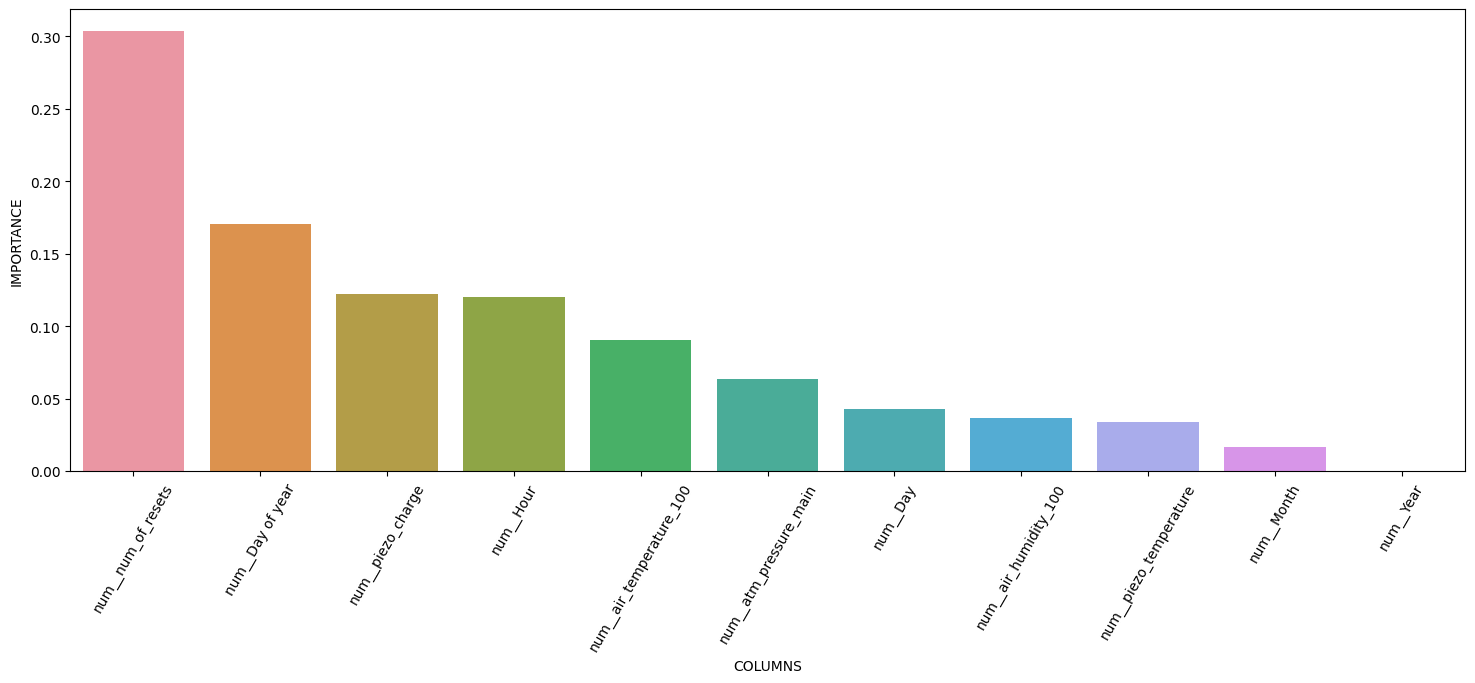

In [463]:
plt.figure(figsize=(18, 6))
plt.xticks(rotation=60)
sns.barplot(df_importance.sort_values("IMPORTANCE", ascending=False), x="COLUMNS", y="IMPORTANCE")
plt.show()

Bora usar shap pra entendermos como cada feature está constribuindo para o nosso modelo. Essa etapa é muito importante, ela permite a redução de dimensionalidade na hora de fazer o deploy do modelo.

In [464]:
booster_xgb = clf.named_steps["regressor"].get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train), pred_contribs=True)
shap_values_xgb = shap_values_xgb[:, :-1]

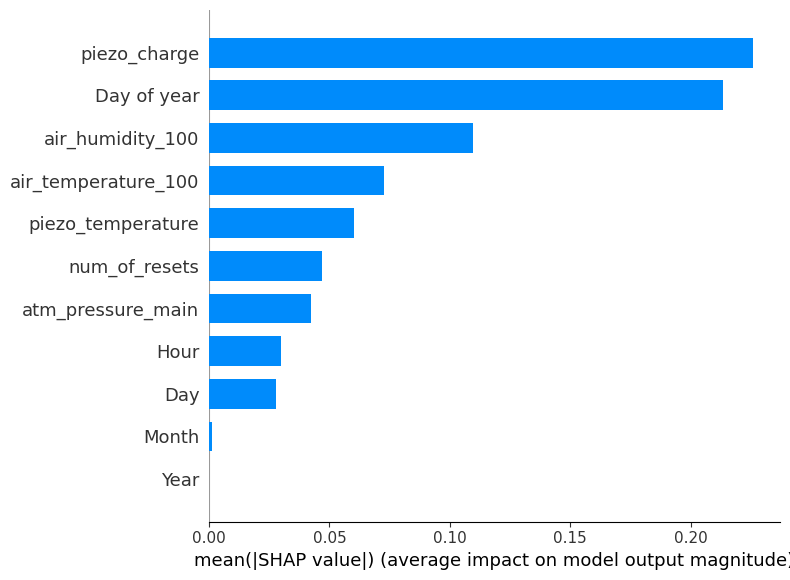

In [465]:
shap.summary_plot(
    shap_values_xgb, X_train, feature_names=X_train.columns, plot_type="bar"
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


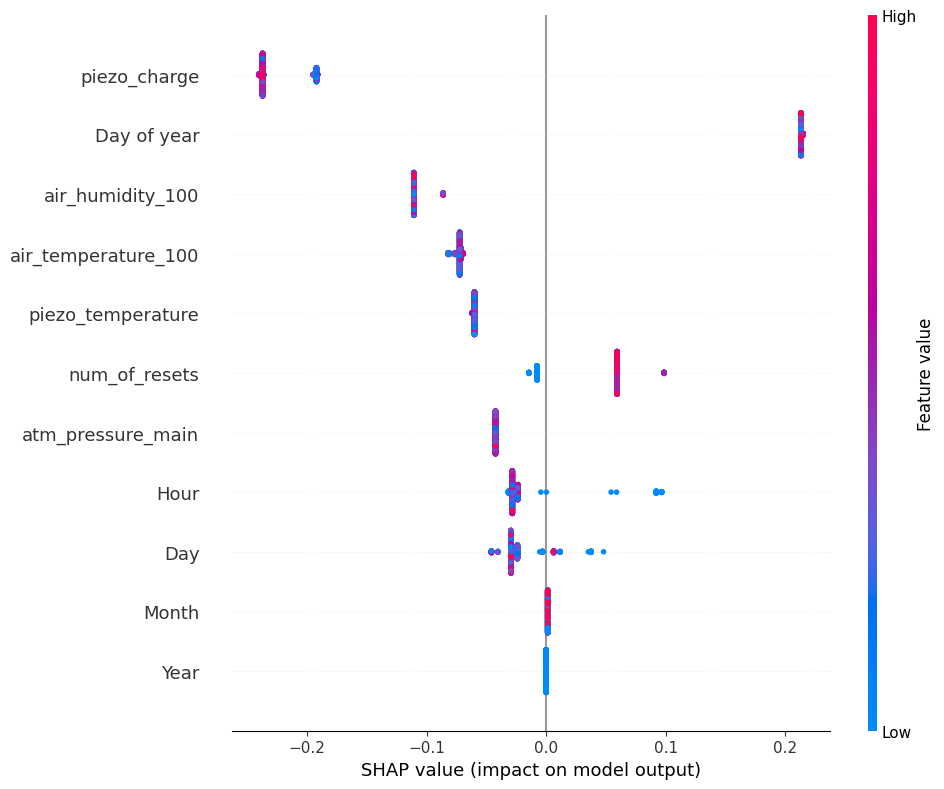

In [466]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns, plot_size=[10,8]);